<a href="https://colab.research.google.com/github/AranyaAryaman/Portfolio-Optimization/blob/main/SAC_vs_LSTM_vs_Transformer_vs_ML_Baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!apt-get -y install libta-lib0 libta-lib0-dev
!pip install ta-lib

!pip install yfinance pandas numpy torch matplotlib scikit-learn quantstats cvxpy scipy seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0
E: Unable to locate package libta-lib0-dev


In [12]:
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import deque
import torch.nn.functional as F
import copy
import time
import quantstats as qs
import cvxpy as cp

from scipy.optimize import minimize
from scipy.spatial.distance import cosine
from sklearn.covariance import LedoitWolf

print("All libraries imported successfully!")

All libraries imported successfully!


In [13]:
SEED = 5
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.set_num_threads(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: Tesla T4


In [14]:
Tickers = [
    "XOM", "V", "PFE", "ADBE", "BHP", "DUK", "NOC", "MRK", "CRM", "SWKS", "TXN", "QCOM",
    "INTC", "AMD", "NVDA", "AMZN", "META", "GOOGL", "MU", "AAPL", "COST", "JPM", "T",
    "TMUS", "AVGO", "COIN", "RIOT", "ON", "MRVL", "ORCL","^VIX","^GSPC"
]

import yfinance as yf

data = yf.download(
    Tickers,
    start="2018-01-01",
    auto_adjust=False,
    group_by="ticker"
)

data.to_pickle("data_stock.pkl")

# Load pickled stock data
stock_df = pd.read_pickle("data_stock.pkl")
stock_close = stock_df.xs('Close', axis=1, level='Price')
returns = stock_close.pct_change(fill_method=None).dropna(how='all')

print(f"Data shape: {stock_df.shape}")
print(f"Date range: {stock_df.index[0]} to {stock_df.index[-1]}")
print(f"Number of tickers: {len(Tickers)}")

[*********************100%***********************]  32 of 32 completed

Data shape: (1999, 192)
Date range: 2018-01-02 00:00:00 to 2025-12-12 00:00:00
Number of tickers: 32


In [15]:
# Calculate annualized standard deviation
daily_vol = returns.std()
annualized_vol = daily_vol * np.sqrt(252)

# Quantiles to define thresholds
low_thresh = annualized_vol.quantile(0.33)
high_thresh = annualized_vol.quantile(0.66)

# Categorize tickers
vol_category = pd.cut(annualized_vol,
                      bins=[-np.inf, low_thresh, high_thresh, np.inf],
                      labels=["Low", "Medium", "High"])

# Results dataframe
vol_df = pd.DataFrame({
    'Annualized Volatility': annualized_vol,
    'Volatility Category': vol_category
})

# Sort tickers by volatility
vol_df = vol_df.sort_values(by='Annualized Volatility')

print("Volatility Categories:")
print(vol_df.head(10))
print(f"\nLow volatility threshold: {low_thresh:.4f}")
print(f"High volatility threshold: {high_thresh:.4f}")

Volatility Categories:
        Annualized Volatility Volatility Category
Ticker                                           
^GSPC                0.196453                 Low
DUK                  0.217868                 Low
COST                 0.227652                 Low
MRK                  0.235480                 Low
T                    0.250591                 Low
PFE                  0.256751                 Low
V                    0.259579                 Low
TMUS                 0.264129                 Low
NOC                  0.268620                 Low
JPM                  0.291575                 Low

Low volatility threshold: 0.3044
High volatility threshold: 0.4127


In [16]:
def calculate_indicators(stock_data):
    try:
        if stock_data is None or stock_data.empty:
            return None

        close_prices = stock_data["Close"].astype(np.float64)
        high_prices = stock_data["High"].astype(np.float64)
        low_prices = stock_data["Low"].astype(np.float64)
        volume = stock_data["Volume"].astype(np.float64)

        data = {
            "MACD": ta.MACD(close_prices)[0].tolist(),
            "RSI": ta.RSI(close_prices).tolist(),
            "CCI": ta.CCI(high_prices, low_prices, close_prices).tolist(),
            "ADX": ta.ADX(high_prices, low_prices, close_prices).tolist(),
            "STOCH_K": ta.STOCH(high_prices, low_prices, close_prices)[0].tolist(),
            "WILLR": ta.WILLR(high_prices, low_prices, close_prices).tolist(),
            "BB_Upper": ta.BBANDS(close_prices)[0].tolist(),
            "BB_Middle": ta.BBANDS(close_prices)[1].tolist(),
            "BB_Lower": ta.BBANDS(close_prices)[2].tolist(),
            "EMA": ta.EMA(close_prices).tolist(),
            "ATR": ta.ATR(high_prices, low_prices, close_prices).tolist(),
            "SAR": ta.SAR(high_prices, low_prices).tolist(),
            "Close_Lag1": close_prices.shift(1).tolist(),
            "Close_Lag3": close_prices.shift(3).tolist(),
            "Close_Lag5": close_prices.shift(5).tolist(),
            "SMA_50": close_prices.rolling(window=50).mean().tolist(),
            "SMA_20": close_prices.rolling(window=20).mean().tolist(),
            "OBV": ta.OBV(close_prices, volume).tolist(),
            "MFI": ta.MFI(high_prices, low_prices, close_prices, volume).tolist(),
        }

        return pd.DataFrame(data, index=stock_data.index)

    except Exception as e:
        print(f"Error processing indicators: {e}")
        return None

print("Technical indicators function defined")

Technical indicators function defined


In [17]:
stock_indicators = {}
tickers_to_drop = ['^VIX', '^GSPC']

# Drop VIX and GSPC market features to calculate stock technical indicators
filtered_stock_df = stock_df.loc[:, ~stock_df.columns.get_level_values('Ticker').isin(tickers_to_drop)]

# Loop over stock tickers
all_indicators = []

for ticker in filtered_stock_df.columns.levels[0]:
    if ticker in tickers_to_drop:
        continue

    stock_data = filtered_stock_df[ticker].dropna()
    indicators_df = calculate_indicators(stock_data)

    if indicators_df is not None:
        indicators_df = indicators_df.reset_index()
        indicators_df["Ticker"] = ticker
        all_indicators.append(indicators_df)

# Combine all indicators into a final DataFrame
if all_indicators:
    final_indicators_df = pd.concat(all_indicators, ignore_index=True)
    print(f"Indicators computed successfully for {len(all_indicators)} stocks!")
    print(f"Shape: {final_indicators_df.shape}")
else:
    print("No valid indicators to save.")

# Extract broad market features (^VIX and ^GSPC)
broad_market_tickers = ['^VIX', '^GSPC']
broad_market_data = stock_df.loc[:, stock_df.columns.get_level_values('Ticker').isin(broad_market_tickers)]

print("Broad market data extracted")

Indicators computed successfully for 30 stocks!
Shape: (59145, 21)
Broad market data extracted


In [18]:
def lambda_schedule(current_step, decay_rate=0.99, min_value=0.02):
    return max(min_value, decay_rate ** current_step)

def prepare_mvo_weights(mvo_weights, batch_size, device):
    if mvo_weights is None:
        return None

    # Convert to torch tensor
    if not torch.is_tensor(mvo_weights):
        mvo_tensor = torch.as_tensor(mvo_weights, dtype=torch.float32)
    else:
        mvo_tensor = mvo_weights

    # Float precision
    mvo_tensor = mvo_tensor.float()

    # Expand dimensions
    if mvo_tensor.dim() == 1:
        mvo_tensor = mvo_tensor.expand(batch_size, -1)
    elif mvo_tensor.dim() == 2 and mvo_tensor.shape[0] == 1:
        mvo_tensor = mvo_tensor.expand(batch_size, -1)
    elif mvo_tensor.shape[0] != batch_size:
        raise ValueError(f"MVO weights batch size mismatch: expected {batch_size}, got {mvo_tensor.shape[0]}")

    return mvo_tensor.to(device)

def temperature_schedule(step, T_max=1.0, T_min=.05, decay_rate=0.001):
    if step is None:
        return torch.tensor(T_max)
    return T_min + (T_max - T_min) * torch.exp(torch.tensor(-decay_rate * step))

print("Helper functions defined")

Helper functions defined


In [19]:
class SACActor(nn.Module):
    def __init__(self, num_assets, asset_feature_dim, macro_feature_dim,
                 hidden_dim=256, log_std_min=-10, log_std_max=2,
                 lambda_mvo=0.3, use_mvo_blending=True):
        super().__init__()
        self.num_assets = num_assets
        self.asset_feature_dim = asset_feature_dim
        self.macro_feature_dim = macro_feature_dim
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.lambda_mvo = lambda_mvo
        self.use_mvo_blending = use_mvo_blending
        self.macro_feature_start_index = self.num_assets * self.asset_feature_dim

        # Asset encoder
        self.asset_encoder = nn.Sequential(
             nn.Linear(asset_feature_dim, hidden_dim),
             nn.LayerNorm(hidden_dim),
             nn.ReLU(),
             nn.Linear(hidden_dim, hidden_dim),
             nn.LayerNorm(hidden_dim),
             nn.ReLU(),
        )

        self.macro_encoder = nn.Sequential(
            nn.Linear(macro_feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )

        self.attention_linear = nn.Linear(hidden_dim, 1)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_assets)
        self.log_std_linear = nn.Linear(hidden_dim, num_assets)

        self.dropout = nn.Dropout(0.1)
        self.activation = nn.ReLU()

    def compute_attention_weights(self, encoded_assets):
        scores = self.attention_linear(encoded_assets).squeeze(-1)
        weights = torch.softmax(scores, dim=-1).unsqueeze(-1)
        return weights

    def encode_state(self, state):
        batch_size = state.size(0)
        total_asset_dim = self.num_assets * self.asset_feature_dim

        asset_flat = state[:, :total_asset_dim]
        macro_feat = state[:, total_asset_dim:]

        asset_feat = asset_flat.view(batch_size, self.num_assets, self.asset_feature_dim)
        encoded_assets = self.asset_encoder(asset_feat)
        weights = self.compute_attention_weights(encoded_assets)
        asset_embed = torch.sum(encoded_assets * weights, dim=1)

        macro_embed = self.macro_encoder(macro_feat)

        x = torch.cat([asset_embed, macro_embed], dim=-1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)

        return x

    def forward(self, state, mvo_weights=None, current_step=None):
        x = self.encode_state(state)

        mean = self.mean_linear(x)
        log_std = torch.clamp(self.log_std_linear(x), self.log_std_min, self.log_std_max)
        std = torch.exp(log_std).clamp(min=1e-6)
        batch_size = state.size(0)

        softmaxed_mean = torch.softmax(mean, dim=-1)

        if mvo_weights is not None:
            alpha_mvo = 0.3
            mvo_tensor = prepare_mvo_weights(mvo_weights, batch_size, mean.device)

            if self.use_mvo_blending:
                mean = alpha_mvo * mvo_tensor + (1 - alpha_mvo) * softmaxed_mean
            else:
                mean = softmaxed_mean

            lambda_mvo = lambda_schedule(current_step) if current_step is not None else 0.1
            self.mvo_reg_loss = lambda_mvo * F.mse_loss(softmaxed_mean, mvo_tensor)

        # Annealing Temperature Schedule
        temperature = temperature_schedule(current_step)

        normal = torch.distributions.Normal(mean, std)
        z = normal.rsample()
        action = torch.softmax(z/temperature, dim=-1)

        log_prob = normal.log_prob(z)
        log_prob = log_prob.sum(dim=-1, keepdim=True)

        return action, log_prob

    def deterministic(self, state):
        with torch.no_grad():
             batch_size = state.size(0)
             total_asset_dim = self.num_assets * self.asset_feature_dim

             asset_flat = state[:, :total_asset_dim]
             macro_feat = state[:, total_asset_dim:]

             asset_feat = asset_flat.view(batch_size, self.num_assets, self.asset_feature_dim)
             encoded_assets = self.asset_encoder(asset_feat)
             weights = self.compute_attention_weights(encoded_assets)
             asset_embed = torch.sum(encoded_assets * weights, dim=1)

             macro_embed = self.macro_encoder(macro_feat)

             x = torch.cat([asset_embed, macro_embed], dim=-1)
             x = self.activation(self.fc1(x))
             x = self.activation(self.fc2(x))

             mean = self.mean_linear(x)
             action = torch.softmax(mean, dim=-1)

             return action, None

print("SAC Actor network defined")

SAC Actor network defined


In [20]:
class SACCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, use_layernorm=True):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.use_layernorm = use_layernorm

        self.q1_net = self.build_critic_net()
        self.q2_net = self.build_critic_net()

    def init_layer(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.orthogonal_(layer.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(layer.bias)

    def build_block(self, in_dim, out_dim):
        layers = [
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        ]
        norm_layer = nn.LayerNorm(out_dim) if self.use_layernorm else nn.BatchNorm1d(out_dim)
        layers.append(norm_layer)
        block = nn.Sequential(*layers)
        for layer in block:
            self.init_layer(layer)
        return block

    def build_critic_net(self):
        return nn.Sequential(
            self.build_block(self.state_dim + self.action_dim, self.hidden_dim),
            self.build_block(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, state, action):
        assert state.size(0) == action.size(0), "Batch size mismatch between state and action"
        x = torch.cat([state, action], dim=1)
        q1 = self.q1_net(x)
        q2 = self.q2_net(x)
        return q1, q2

print("SAC Critic network defined")

SAC Critic network defined


In [21]:
class ReplayBuffer:
    def __init__(self, max_size=500000):
        self.max_size = max_size
        self.storage = []
        self.ptr = 0

    def add(self, data):
        if len(self.storage) < self.max_size:
            self.storage.append(data)
        else:
            self.storage[self.ptr] = data
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in ind:
            s, a, r, s2, d = self.storage[i]
            states.append(np.asarray(s))
            actions.append(np.asarray(a))
            rewards.append(np.asarray(r))
            next_states.append(np.asarray(s2))
            dones.append(np.asarray(d))
        return (
             np.stack(states),
             np.stack(actions),
             np.stack(rewards),
             np.stack(next_states),
             np.stack(dones)
        )

    def __len__(self):
        return len(self.storage)

print("Replay Buffer defined")

Replay Buffer defined


In [22]:
class SACAgent:
    def __init__(self, state_dim, num_assets, hidden_dim=256, init_alpha=1, gamma=0.99,
                 tau=0.01, target_entropy=None, use_mvo=False, lambda_mvo=0.3):
        self.use_mvo = use_mvo
        self.lambda_mvo = lambda_mvo
        self.reward_history = deque(maxlen=1000)

        self.actor = SACActor(
            num_assets=num_assets,
            asset_feature_dim=19,
            macro_feature_dim=state_dim - num_assets * 19,
            hidden_dim=hidden_dim,
            lambda_mvo=lambda_mvo,
            use_mvo_blending=use_mvo
        ).to(device)

        self.critic = SACCritic(state_dim, num_assets, hidden_dim).to(device)
        self.critic_target = SACCritic(state_dim, num_assets, hidden_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=5e-4)

        # Entropy Temperature (Alpha)
        self.log_alpha = torch.nn.Parameter(torch.tensor(np.log(init_alpha)))
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=5e-4)

        if target_entropy is None:
           self.target_entropy = -num_assets * 0.5
        else:
             self.target_entropy = target_entropy

        self.gamma = gamma
        self.tau = tau

        self.replay_buffer = ReplayBuffer()
        self.total_it = 0

        self.reward_mean = 0.0
        self.reward_std = 1.0

    @property
    def alpha(self):
        decay_rate = 0.99
        decay_step = self.total_it // 100
        annealed_log_alpha = self.log_alpha - decay_step * np.log(decay_rate)
        return annealed_log_alpha.exp()

    def soft_update(self, target_net, source_net):
        for target_param, param in zip(target_net.parameters(), source_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def select_action(self, state, evaluate=False, mvo_weights=None):
        state_tensor = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
            if evaluate:
                action, _ = self.actor.deterministic(state_tensor)
            else:
                action, _ = self.actor(state_tensor, mvo_weights=mvo_weights)
        return action.cpu().numpy()[0]

print("SAC Agent defined")

SAC Agent defined


In [30]:
# Cell 13: Define MVO Weight Computation (FIXED - Handles NaN values)

# Filter volatility dataframe
vol_df_filtered = vol_df[~vol_df.index.isin(['^GSPC', '^VIX'])]

def compute_mvo_weights(price_data, feature_matrix, current_step, num_assets, asset_feature_dim, window=60):
    asset_features = feature_matrix[current_step][:num_assets * asset_feature_dim]
    asset_features = asset_features.reshape(num_assets, asset_feature_dim)
    expected_returns = asset_features[:, 0]

    # Handle NaN in expected returns
    if np.isnan(expected_returns).any():
        expected_returns = np.nan_to_num(expected_returns, nan=0.0)

    start_idx = max(0, current_step - window)
    price_slice = price_data[start_idx:current_step]

    if price_slice.shape[0] < 2:
        cov_matrix = np.eye(num_assets)
    else:
        returns = price_slice[1:] / price_slice[:-1] - 1

        # Handle NaN and inf values in returns
        returns = np.nan_to_num(returns, nan=0.0, posinf=0.0, neginf=0.0)

        if returns.shape[0] < 2:
            cov_matrix = np.eye(num_assets)
        else:
            # Check if returns has valid variance
            if np.all(returns.std(axis=0) == 0):
                cov_matrix = np.eye(num_assets)
            else:
                try:
                    # Additional check: remove columns with zero variance
                    valid_cols = returns.std(axis=0) > 1e-8
                    if valid_cols.sum() < 2:
                        cov_matrix = np.eye(num_assets)
                    else:
                        # Use only valid columns for covariance estimation
                        valid_returns = returns[:, valid_cols]
                        cov_estimator = LedoitWolf()
                        partial_cov = cov_estimator.fit(valid_returns).covariance_

                        # Reconstruct full covariance matrix
                        cov_matrix = np.eye(num_assets) * 0.01  # Small diagonal for invalid assets
                        valid_indices = np.where(valid_cols)[0]
                        for i, idx_i in enumerate(valid_indices):
                            for j, idx_j in enumerate(valid_indices):
                                cov_matrix[idx_i, idx_j] = partial_cov[i, j]
                except Exception as e:
                    print(f"[MVO] Covariance estimation failed: {e}, using identity matrix")
                    cov_matrix = np.eye(num_assets)

    try:
        w = cp.Variable(num_assets)
        Sigma = 0.5 * (cov_matrix + cov_matrix.T)

        # Add small regularization to ensure positive definiteness
        Sigma_reg = Sigma + np.eye(num_assets) * 1e-6

        objective = cp.Maximize(expected_returns @ w - 0.5 * cp.quad_form(w, Sigma_reg))
        constraints = [cp.sum(w) == 1, w >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.OSQP, verbose=False)

        weights = w.value
        if weights is None or not np.all(np.isfinite(weights)):
            raise ValueError("Solver returned invalid weights")

        # Ensure weights sum to 1 and are non-negative
        weights = np.clip(weights, 0, 1)
        weights = weights / weights.sum()

    except Exception as e:
        print(f"[MVO] Optimization failed at step {current_step}: {e}")
        weights = np.array([1.0 / num_assets] * num_assets)

    return weights

print("MVO weight computation function defined (with NaN handling)")

MVO weight computation function defined (with NaN handling)


In [24]:
# Cell 14: Define Portfolio Environment (Part 1 - Init and Reset)

class SACEnv:
    def __init__(self, price_data, feature_matrix, stock_list, max_steps=None):
        """
        price_data: numpy array with shape (T, N_stocks) holding close prices
        feature_matrix: numpy array with shape (T, feature_dim) holding features aligned by date
        stock_list: list of stock tickers corresponding to columns in price_data
        max_steps: max number of steps per episode
        """
        self.price_data = price_data
        self.feature_matrix = feature_matrix
        self.stock_list = stock_list

        self.max_steps = max_steps or (len(self.price_data) - 2)

        self.num_assets = len(stock_list)
        self.stock_list = stock_list
        self.asset_feature_dim = 19
        self.current_step = 0
        self.ema_return = 0
        self.ema_std = 0
        self.prev_reward = 0.0

        self.prev_weights = np.array([1.0 / self.num_assets] * self.num_assets)

        # Map volatility categories to one-hot encodings
        vol_map = {'Low': [1, 0, 0], 'Medium': [0, 1, 0], 'High': [0, 0, 1]}

        self.vol_cat_matrix = np.array([
             vol_map[vol_df_filtered.loc[ticker, 'Volatility Category']]
             for ticker in self.stock_list
        ])

    def reset(self):
        self.current_step = np.random.randint(0, len(self.feature_matrix) - self.max_steps)
        self.prev_weights = np.array([1.0 / self.num_assets] * self.num_assets)
        self.weights = self.prev_weights.copy()
        self.portfolio_value = 1.0
        self.peak_value = 1.0
        self.smoothing_window = 60
        self.portfolio_returns = [0.0] * self.smoothing_window

        return self._get_state()

    def _get_state(self):
         return self.feature_matrix[self.current_step]

In [25]:
def step_function_for_env(self, action_raw):
    """
    action_raw: numpy array or torch tensor with values in [-1,1] from SAC actor
    """
    if isinstance(action_raw, torch.Tensor):
        action_raw = action_raw.cpu().detach().numpy()

    weights = action_raw
    cos_sim = 1 - cosine(weights, self.prev_weights)

    # Calculate asset returns from data prices
    prices_t = self.price_data[self.current_step]
    prices_tp1 = self.price_data[self.current_step + 1]
    asset_returns = (prices_tp1 - prices_t) / prices_t
    asset_returns = np.nan_to_num(asset_returns)

    # Transaction cost based on turnover
    turnover_raw = np.abs(weights - self.prev_weights)
    turnover = np.clip(np.log1p(np.sum(turnover_raw)), 0, 1.0)

    default_transaction_cost = 0.001
    slippage = 0.0001 * np.sum((weights - self.prev_weights)**2)
    cost = turnover * default_transaction_cost + slippage

    portfolio_returns = np.dot(weights, asset_returns)

    self.portfolio_returns.append(portfolio_returns)
    if len(self.portfolio_returns) > self.smoothing_window:
       self.portfolio_returns.pop(0)

    rf_daily = (1 + 0.0442) ** (1 / 252) - 1
    mean_return = np.mean(self.portfolio_returns[-self.smoothing_window:])
    std_return = np.std(self.portfolio_returns[-self.smoothing_window:]) + 1e-8

    # Lambda design strategy
    base_λ_dd = 0.1
    base_cvar = 0.1
    base_λ_vol = 0.1
    base_λ_ret = 1
    base_λ_entropy = 0.1
    decay_rate = 0.3

    # EMA smoothing for Sharpe-like reward
    alpha = 0.1
    self.ema_return = (1 - alpha) * self.ema_return + alpha * portfolio_returns
    self.ema_std = (1 - alpha) * self.ema_std + alpha * np.abs(portfolio_returns - self.ema_return)

    sharpe_like_reward = (self.ema_return - rf_daily) / (self.ema_std + 1e-6)

    # Smoothed short-term volatility
    returns_window = self.portfolio_returns[-self.smoothing_window:]
    volatility = np.std(returns_window) + 1e-6

    # Normalize volatility by average absolute return
    avg_abs_return = np.mean(np.abs(returns_window)) + 1e-6
    vol_penalty = volatility / avg_abs_return

    # Asset-specific volatility weighting
    asset_vols = np.array([
          vol_df_filtered.loc[ticker, 'Annualized Volatility']
          for ticker in self.stock_list
    ])
    weighted_vol_penalty = np.sum(weights * asset_vols) / (np.mean(asset_vols) + 1e-6)

    # Final volatility penalty
    λ_vol = base_λ_vol * (vol_penalty + 0.05 * weighted_vol_penalty)

    # Stability bonus
    stability_bonus = np.exp(-np.abs(portfolio_returns - self.ema_return))
    bonus_scale = np.clip((sharpe_like_reward + 1) / 1, 0.1, 1.0)
    λ_stability = bonus_scale * stability_bonus

    λ_ret = base_λ_ret * (1 + sharpe_like_reward)

    # Update portfolio value and peak
    self.portfolio_value *= (1 + portfolio_returns)
    self.peak_value = max(self.peak_value, self.portfolio_value)

    # Compute drawdown
    drawdown = (self.peak_value - self.portfolio_value) / self.peak_value
    penalized_dd = max(0.0, drawdown - 0.05)
    normalized_drawdown = penalized_dd / (volatility + 1e-6)
    λ_dd = base_λ_dd * normalized_drawdown

    # Entropy
    clipped_weights = np.clip(weights, 1e-6, 1)
    weight_entropy = -np.sum(clipped_weights * np.log(clipped_weights)) / np.log(len(weights))

    # Decay factor for entropy encouragement
    decay_factor = 0.1 + 0.9 * np.exp(-decay_rate * self.current_step / self.max_steps)
    vol_factor = 1 + 0.2 * np.exp(-volatility)

    # Penalty terms for low entropy
    linear_penalty = max(0, 0.5 - weight_entropy)
    quadratic_penalty = (1 - weight_entropy) ** 2

    entropy_score = weight_entropy - 0.1 * linear_penalty - 0.1 * quadratic_penalty
    λ_entropy = base_λ_entropy * decay_factor * vol_factor * entropy_score

    # CVaR computation
    confidence_level = 0.05
    buffer_size = min(len(self.portfolio_returns), self.smoothing_window)
    recent_returns = self.portfolio_returns[-buffer_size:]

    sorted_returns = np.sort(recent_returns)
    cvar_cutoff = max(1, int(confidence_level * buffer_size))
    cvar = -np.mean(sorted_returns[:cvar_cutoff]) if cvar_cutoff > 0 else 0.0
    λ_cvar = base_cvar * (1 + cvar / (volatility + 1e-6))

    # MVO weights
    mvo_weights = compute_mvo_weights(
               self.price_data,
               self.feature_matrix,
               self.current_step,
               self.num_assets,
               self.asset_feature_dim
    )

    mvo_return = np.dot(mvo_weights, asset_returns)

    # Compute reward
    reward = (
            λ_ret
           - λ_vol
           - λ_dd
           - λ_cvar
           - min(cost, 0.001)
           + λ_entropy
           + λ_stability
    )

    # MVO Comparison
    mvo_excess = portfolio_returns - mvo_return
    mvo_bonus = np.clip(0.2 + 0.1 * (mvo_excess / (volatility + 1e-4)), 0.05, 0.2)

    # Entropy alignment with MVO
    mvo_entropy = -np.sum(mvo_weights * np.log(mvo_weights + 1e-6)) / np.log(len(mvo_weights))
    mvo_similarity_bonus = 0.1 * (weight_entropy / (mvo_entropy + 1e-6))

    reward += mvo_bonus + mvo_similarity_bonus

    # Momentum Modulation
    momentum_factor = np.clip(
        (portfolio_returns - self.ema_return) / (self.ema_std + 1e-6),
        -5, 5
    )

    # Reward smoothing
    smoothed_reward = self.prev_reward + 0.2 * (reward - self.prev_reward)
    mvo_gain = momentum_factor * (mvo_bonus - cost)
    adjusted_reward = 0.9 * smoothed_reward + 0.1 * (reward + mvo_gain)

    reward = np.clip(adjusted_reward, -1.0, 1.0)
    self.prev_reward = reward

    # Update internal state
    self.weights = weights
    self.prev_weights = weights

    info = {
         "portfolio_return": portfolio_returns,
         "weights": weights,
         "transaction_cost": cost,
         "sharpe_like_reward": sharpe_like_reward,
         "mean_return": mean_return,
         "std_return": std_return,
         "drawdown": drawdown,
         "cvar": cvar,
         "weight_entropy": weight_entropy,
         "cosine_similarity": cos_sim,
         "mvo_return": mvo_return,
         "mvo_excess": mvo_excess
    }

    self.current_step += 1
    done = self.current_step >= self.max_steps

    next_state = self._get_state()
    return next_state, reward, done, info

# Add step method to SACEnv class
SACEnv.step = step_function_for_env

print("Environment step function defined and added to SACEnv class")

Environment step function defined and added to SACEnv class


In [26]:
# Cell 16: Define Agent Update Method

def agent_update_method(self, batch_size=32, mvo_weights=None):
    if len(self.replay_buffer) < max(100, batch_size) or self.total_it < 100:
        return

    self.total_it += 1
    state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

    state = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action = torch.FloatTensor(action).to(device)
    reward = torch.FloatTensor(reward).to(device)
    done = torch.FloatTensor(done).to(device)

    # Critic update
    with torch.no_grad():
        next_action, next_log_prob = self.actor(next_state, mvo_weights=mvo_weights)
        target_q1, target_q2 = self.critic_target(next_state, next_action)
        target_q = torch.min(target_q1, target_q2) - self.alpha * next_log_prob

        reward_clip = torch.clamp(reward, reward.quantile(0.05), reward.quantile(0.95))

        reward_np = reward_clip.cpu().numpy()
        self.reward_history.extend(reward_np.tolist())

        if len(self.reward_history) >= 50:
           self.reward_mean = np.mean(self.reward_history)
           self.reward_std = np.std(self.reward_history) + 1e-6
        else:
             self.reward_mean = 0.0
             self.reward_std = 1.0
        normalized_reward = (reward_clip - self.reward_mean) / (self.reward_std + 1e-6)

        q_target = normalized_reward + (1 - done) * self.gamma * target_q

    q1_pred, q2_pred = self.critic(state, action)
    critic_loss = nn.functional.mse_loss(q1_pred, q_target) + nn.functional.mse_loss(q2_pred, q_target)

    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
    self.critic_optimizer.step()

    # Actor update
    new_action, log_prob = self.actor(state, mvo_weights=mvo_weights)
    q1_pi, q2_pi = self.critic(state, new_action)
    min_q = torch.min(q1_pi, q2_pi)
    actor_loss = (self.alpha * log_prob - min_q).mean()

    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
    self.actor_optimizer.step()

    # Alpha update
    alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
    self.alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.alpha_optimizer.step()

    self.soft_update(self.critic_target, self.critic)

# Add update method to SACAgent class
SACAgent.update = agent_update_method

print("Agent update method defined and added to SACAgent class")

Agent update method defined and added to SACAgent class


In [27]:
def cosine_actor_lr(base=5e-4, min_lr=1e-5, t=0, T_max=300, restart_interval=100):
    cycle = np.floor(1 + t / restart_interval)
    x = np.abs(t / restart_interval - 2 * cycle + 1)
    return min_lr + 0.5 * (base - min_lr) * (1 + np.cos(np.pi * x))

num_episodes = 300

def sac_train_agent(agent, env, max_episodes=num_episodes, max_steps=None, batch_size=64):
    POLICY_DELAY = 3
    critic_loss_history = []
    actor_loss_history = []
    reward_history = []
    sharpe_history = []
    alpha_history = []
    weights_history = []
    final_weights_history = []
    portfolio_returns_history = []
    episode_returns = []
    episode_gap = []
    sac_mvo_history = []

    max_steps = max_steps or env.max_steps

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        episode_weights = None
        episode_sharpe = []
        episode_critic_losses = []
        episode_actor_losses = []
        last_info = None

        mvo_weights = compute_mvo_weights(
                env.price_data,
                env.feature_matrix,
                env.current_step,
                env.num_assets,
                env.asset_feature_dim
        )
        agent.current_mvo_weights = mvo_weights

        for step in range(max_steps):
            assert not np.isnan(state).any(), f"NaN in state at step {step}"
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

            with torch.no_grad():
                action_tensor, _ = agent.actor(state_tensor)
            action = action_tensor.cpu().numpy().flatten()

            next_state, reward, done, info = env.step(action)

            last_info = info
            episode_reward += reward

            episode_sharpe.append(info.get("sharpe_like_reward", 0.0))
            episode_returns.append(info["portfolio_return"])
            episode_gap.append(info["mvo_excess"])

            agent.replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state

            if len(agent.replay_buffer) > batch_size:
                agent.total_it += 1

                state_batch, action_batch, reward_batch, next_state_batch, done_batch = agent.replay_buffer.sample(batch_size)

                state_batch = torch.FloatTensor(state_batch).to(device)
                action_batch = torch.FloatTensor(action_batch).to(device)
                reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
                next_state_batch = torch.FloatTensor(next_state_batch).to(device)
                done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(device)

                # Preprocess MVO weights
                mvo_tensor = prepare_mvo_weights(mvo_weights, batch_size=state_batch.size(0), device=state_batch.device)

                with torch.no_grad():
                     next_action, next_log_prob = agent.actor(next_state_batch, mvo_weights=mvo_tensor)
                     target_q1, target_q2 = agent.critic_target(next_state_batch, next_action)
                     target_q = torch.min(target_q1, target_q2) - agent.alpha * next_log_prob
                     q_target = reward_batch + (1 - done_batch) * agent.gamma * target_q
                     q_target = q_target.detach()

                current_q1, current_q2 = agent.critic(state_batch, action_batch)
                critic_loss = F.mse_loss(current_q1, q_target) + F.mse_loss(current_q2, q_target)
                critic_loss = 0.05 * critic_loss
                episode_critic_losses.append(critic_loss.item())

                agent.critic_optimizer.zero_grad()
                critic_loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), max_norm=1)

                if agent.total_it % 10 == 0:
                    agent.critic_optimizer.param_groups[0]['lr'] = cosine_actor_lr(t=episode)
                agent.critic_optimizer.step()

                if agent.total_it % POLICY_DELAY == 0:
                   agent.actor_optimizer.param_groups[0]['lr'] = cosine_actor_lr(t=episode)

                   new_action, log_prob = agent.actor(state_batch, mvo_weights=mvo_weights)
                   q1_pi, q2_pi = agent.critic(state_batch, new_action)
                   min_q = torch.min(q1_pi, q2_pi)

                   base_loss = (agent.alpha * log_prob - min_q).mean()
                   actor_loss = base_loss
                   entropy_loss = -log_prob.mean()
                   actor_loss = base_loss + 0.01 * entropy_loss

                   diversity_loss = torch.std(new_action, dim=1).mean()
                   actor_loss += diversity_loss

                   if agent.use_mvo and agent.current_mvo_weights is not None:
                     target = agent.current_mvo_weights
                     if isinstance(target, np.ndarray):
                        target = torch.FloatTensor(target).to(new_action.device)

                     if target.ndim == 1:
                        target = target.unsqueeze(0).expand(new_action.size(0), -1)
                     elif target.ndim == 2 and target.size(0) != new_action.size(0):
                          target = target.expand(new_action.size(0), -1)

                     tracking_error = F.mse_loss(new_action, target)
                     agent.lambda_mvo = lambda_schedule(agent.total_it)

                     if agent.use_mvo and hasattr(agent.actor, "mvo_reg_loss"):
                         actor_loss += agent.lambda_mvo * (0.5 * agent.actor.mvo_reg_loss + 0.5 * tracking_error)

                   episode_actor_losses.append(actor_loss.item())

                   agent.actor_optimizer.zero_grad()
                   actor_loss.backward()
                   torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), max_norm=1.0)
                   agent.actor_optimizer.step()

                   alpha_loss = -(agent.log_alpha * (log_prob + agent.target_entropy).detach()).mean()
                   agent.alpha_optimizer.zero_grad()
                   alpha_loss.backward()
                   agent.alpha_optimizer.step()

                   agent.soft_update(agent.critic_target, agent.critic)

            if done:
                break

        # Episode statistics
        reward_history.append(episode_reward)

        if last_info is not None:
            final_weights_history.append(last_info["weights"])
            portfolio_returns_history.append(last_info["portfolio_return"])
            sac_mvo_history.append(last_info["mvo_excess"])

        if len(episode_sharpe) > 0:
            sharpe_history.append(np.mean(episode_sharpe))

        if len(episode_critic_losses) > 0:
            critic_loss_history.append(np.mean(episode_critic_losses))

        if len(episode_actor_losses) > 0:
            actor_loss_history.append(np.mean(episode_actor_losses))

        alpha_history.append(agent.alpha.item())

        if episode % 10 == 0:
            print(f"Episode {episode}/{max_episodes} | Reward: {episode_reward:.4f} | "
                  f"Alpha: {agent.alpha.item():.4f} | "
                  f"Sharpe: {np.mean(episode_sharpe):.4f} | "
                  f"Buffer: {len(agent.replay_buffer)}")

    return (reward_history, weights_history, final_weights_history, alpha_history,
            portfolio_returns_history, critic_loss_history, actor_loss_history,
            sac_mvo_history, sharpe_history)

print("Training function defined")

Training function defined


In [31]:
# Cell 18: Prepare Data for Training (FIXED - Proper feature engineering)

print("Preparing training and test data...")

# Get unique dates
dates = sorted(stock_close.index.unique())
print(f"Total dates available: {len(dates)}")

# Define train/test split (e.g., 80/20)
train_size = int(0.8 * len(dates))
train_dates = dates[:train_size]
test_dates = dates[train_size:]

print(f"Training dates: {train_dates[0]} to {train_dates[-1]}")
print(f"Testing dates: {test_dates[0]} to {test_dates[-1]}")

# Filter out market indices for portfolio stocks
portfolio_stocks = [t for t in Tickers if t not in ['^VIX', '^GSPC']]
print(f"Portfolio stocks: {len(portfolio_stocks)}")

# Create price data arrays for train and test
train_price_data = stock_close[portfolio_stocks].loc[train_dates].values
test_price_data = stock_close[portfolio_stocks].loc[test_dates].values

print(f"Train price data shape: {train_price_data.shape}")
print(f"Test price data shape: {test_price_data.shape}")

def create_feature_matrix_from_indicators(indicators_df, price_data, dates, stock_list):
    """
    Create feature matrix from technical indicators dataframe
    """
    n_periods = len(dates)
    n_stocks = len(stock_list)
    asset_feature_dim = 19  # As defined in your code

    # Initialize feature matrix
    all_features = []

    for date_idx, date in enumerate(dates):
        period_features = []

        # Asset-level features for each stock
        for stock in stock_list:
            stock_features = []

            # Get indicators for this stock and date
            stock_indicators = indicators_df[
                (indicators_df['Ticker'] == stock) &
                (indicators_df['Date'] == date)
            ]

            if len(stock_indicators) > 0:
                row = stock_indicators.iloc[0]

                # Extract 19 features (adjust based on your actual indicators)
                feature_names = ['MACD', 'RSI', 'CCI', 'ADX', 'STOCH_K', 'WILLR',
                                'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA', 'ATR',
                                'SAR', 'Close_Lag1', 'Close_Lag3', 'Close_Lag5',
                                'SMA_50', 'SMA_20', 'OBV', 'MFI']

                for feat in feature_names:
                    if feat in row:
                        val = row[feat]
                        stock_features.append(val if not pd.isna(val) else 0.0)
                    else:
                        stock_features.append(0.0)
            else:
                # If no indicators available, use zeros
                stock_features = [0.0] * asset_feature_dim

            period_features.extend(stock_features)

        # Add macro features (VIX, GSPC)
        # Extract from broad_market_data
        if date in broad_market_data.index:
            vix_close = broad_market_data.loc[date, ('^VIX', 'Close')]
            gspc_close = broad_market_data.loc[date, ('^GSPC', 'Close')]

            vix_val = vix_close if not pd.isna(vix_close) else 0.0
            gspc_val = gspc_close if not pd.isna(gspc_close) else 0.0

            period_features.extend([vix_val, gspc_val])
        else:
            period_features.extend([0.0, 0.0])

        all_features.append(period_features)

    feature_matrix = np.array(all_features)

    # Replace any remaining NaN or inf values
    feature_matrix = np.nan_to_num(feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    return feature_matrix

# Create feature matrices
print("Creating feature matrices from indicators...")

# Make sure Date column exists in final_indicators_df
if 'Date' not in final_indicators_df.columns and 'index' in final_indicators_df.columns:
    final_indicators_df = final_indicators_df.rename(columns={'index': 'Date'})

train_feature_matrix = create_feature_matrix_from_indicators(
    final_indicators_df, train_price_data, train_dates, portfolio_stocks
)
test_feature_matrix = create_feature_matrix_from_indicators(
    final_indicators_df, test_price_data, test_dates, portfolio_stocks
)

print(f"Train feature matrix shape: {train_feature_matrix.shape}")
print(f"Test feature matrix shape: {test_feature_matrix.shape}")

# Check for NaN values before scaling
print(f"\nNaN values in train features: {np.isnan(train_feature_matrix).sum()}")
print(f"Inf values in train features: {np.isinf(train_feature_matrix).sum()}")

# Scale features
scaler = StandardScaler()
train_feature_matrix = scaler.fit_transform(train_feature_matrix)
test_feature_matrix = scaler.transform(test_feature_matrix)

# Final check after scaling
train_feature_matrix = np.nan_to_num(train_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
test_feature_matrix = np.nan_to_num(test_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nAfter scaling - NaN in train: {np.isnan(train_feature_matrix).sum()}")
print(f"After scaling - Inf in train: {np.isinf(train_feature_matrix).sum()}")

print("\nFeature matrices created and scaled successfully")
print(f"State dimension: {train_feature_matrix.shape[1]}")
print(f"Number of assets: {len(portfolio_stocks)}")

Preparing training and test data...
Total dates available: 1999
Training dates: 2018-01-02 00:00:00 to 2024-05-09 00:00:00
Testing dates: 2024-05-10 00:00:00 to 2025-12-12 00:00:00
Portfolio stocks: 30
Train price data shape: (1599, 30)
Test price data shape: (400, 30)
Creating feature matrices from indicators...
Train feature matrix shape: (1599, 572)
Test feature matrix shape: (400, 572)

NaN values in train features: 0
Inf values in train features: 0

After scaling - NaN in train: 0
After scaling - Inf in train: 0

Feature matrices created and scaled successfully
State dimension: 572
Number of assets: 30


In [32]:
# Cell 19: Initialize Environment and Agent, Start Training

# Create training environment
print("Initializing training environment...")
train_env = SACEnv(
    price_data=train_price_data,
    feature_matrix=train_feature_matrix,
    stock_list=portfolio_stocks,
    max_steps=200  # Adjust as needed
)

# Create test environment
print("Initializing test environment...")
test_env = SACEnv(
    price_data=test_price_data,
    feature_matrix=test_feature_matrix,
    stock_list=portfolio_stocks,
    max_steps=200  # Adjust as needed
)

# Get dimensions
state_dim = train_feature_matrix.shape[1]
action_dim = len(portfolio_stocks)

print(f"\nEnvironment Configuration:")
print(f"State dimension: {state_dim}")
print(f"Action dimension (num assets): {action_dim}")
print(f"Training episodes max steps: {train_env.max_steps}")

# Initialize SAC Agent
print("\nInitializing SAC Agent...")
agent = SACAgent(
    state_dim=state_dim,
    num_assets=action_dim,
    hidden_dim=256,
    init_alpha=1.0,
    gamma=0.99,
    tau=0.01,
    use_mvo=True,
    lambda_mvo=0.3
)

print(f"Actor parameters: {sum(p.numel() for p in agent.actor.parameters()):,}")
print(f"Critic parameters: {sum(p.numel() for p in agent.critic.parameters()):,}")

# Start training
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

(reward_history, weights_history, final_weights_history, alpha_history,
 portfolio_returns_history, critic_loss_history, actor_loss_history,
 sac_mvo_history, sharpe_history) = sac_train_agent(
    agent=agent,
    env=train_env,
    max_episodes=num_episodes,
    batch_size=64
)

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)

# Save the trained model
torch.save({
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'critic_target_state_dict': agent.critic_target.state_dict(),
    'actor_optimizer': agent.actor_optimizer.state_dict(),
    'critic_optimizer': agent.critic_optimizer.state_dict(),
}, 'sac_portfolio_model.pth')

print("\nModel saved to 'sac_portfolio_model.pth'")

Initializing training environment...
Initializing test environment...

Environment Configuration:
State dimension: 572
Action dimension (num assets): 30
Training episodes max steps: 200

Initializing SAC Agent...
Actor parameters: 286,013
Critic parameters: 442,882

STARTING TRAINING

Episode 0/300 | Reward: 1.0000 | Alpha: 1.0000 | Sharpe: -1.1893 | Buffer: 1
Episode 10/300 | Reward: 1.0000 | Alpha: 0.9881 | Sharpe: 0.0763 | Buffer: 137
Episode 20/300 | Reward: 1.0000 | Alpha: 0.9866 | Sharpe: -0.3841 | Buffer: 147
Episode 30/300 | Reward: 1.0000 | Alpha: 0.9771 | Sharpe: -0.4346 | Buffer: 257
Episode 40/300 | Reward: 48.0000 | Alpha: 0.9680 | Sharpe: 0.0015 | Buffer: 389
Episode 50/300 | Reward: 200.0000 | Alpha: 0.9291 | Sharpe: 0.0919 | Buffer: 749
Episode 60/300 | Reward: 1.0000 | Alpha: 0.9181 | Sharpe: -0.3742 | Buffer: 979
Episode 70/300 | Reward: 1.0000 | Alpha: 0.9033 | Sharpe: 0.3933 | Buffer: 1184
Episode 80/300 | Reward: 1.0000 | Alpha: 0.9019 | Sharpe: -0.2239 | Buffer: 1

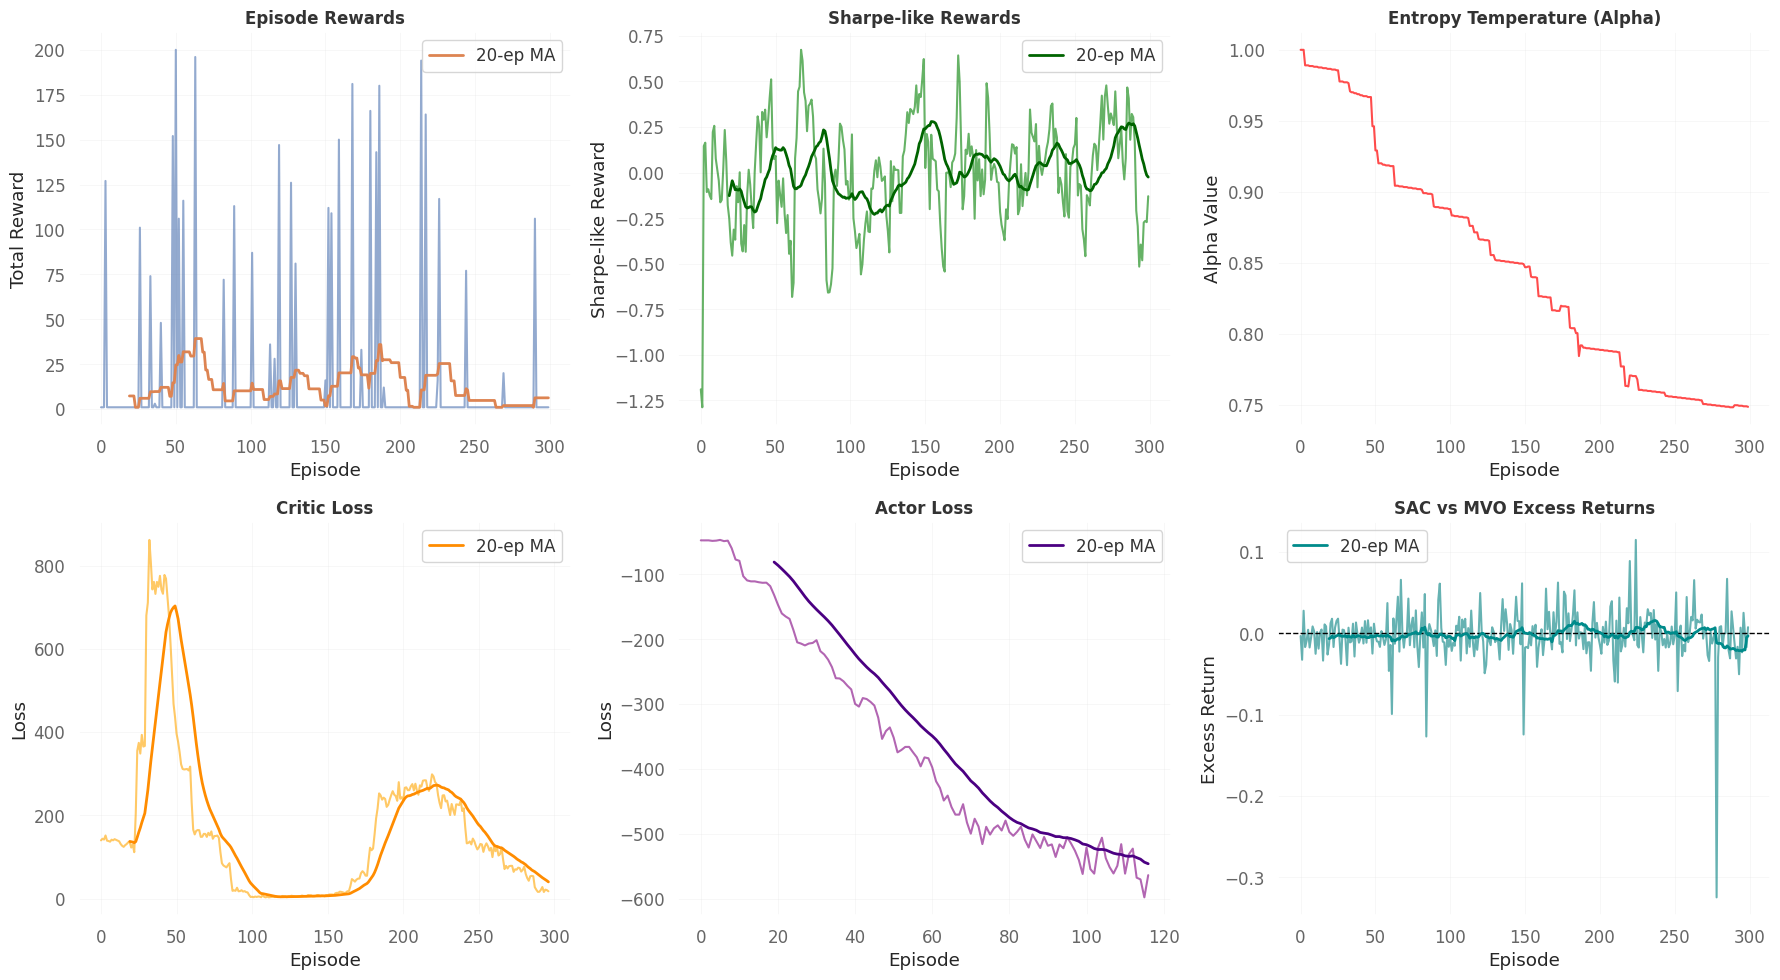

Training visualizations saved to 'training_progress.png'


In [33]:
# Cell 20: Visualize Training Progress

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Reward history
axes[0, 0].plot(reward_history, alpha=0.6)
axes[0, 0].plot(pd.Series(reward_history).rolling(20).mean(), linewidth=2, label='20-ep MA')
axes[0, 0].set_title('Episode Rewards', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Sharpe-like rewards
axes[0, 1].plot(sharpe_history, alpha=0.6, color='green')
axes[0, 1].plot(pd.Series(sharpe_history).rolling(20).mean(), linewidth=2, label='20-ep MA', color='darkgreen')
axes[0, 1].set_title('Sharpe-like Rewards', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Sharpe-like Reward')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Alpha (entropy temperature)
axes[0, 2].plot(alpha_history, alpha=0.7, color='red')
axes[0, 2].set_title('Entropy Temperature (Alpha)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('Alpha Value')
axes[0, 2].grid(True, alpha=0.3)

# Critic loss
if len(critic_loss_history) > 0:
    axes[1, 0].plot(critic_loss_history, alpha=0.6, color='orange')
    axes[1, 0].plot(pd.Series(critic_loss_history).rolling(20).mean(), linewidth=2, label='20-ep MA', color='darkorange')
    axes[1, 0].set_title('Critic Loss', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Actor loss
if len(actor_loss_history) > 0:
    axes[1, 1].plot(actor_loss_history, alpha=0.6, color='purple')
    axes[1, 1].plot(pd.Series(actor_loss_history).rolling(20).mean(), linewidth=2, label='20-ep MA', color='indigo')
    axes[1, 1].set_title('Actor Loss', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# SAC vs MVO excess returns
if len(sac_mvo_history) > 0:
    axes[1, 2].plot(sac_mvo_history, alpha=0.6, color='teal')
    axes[1, 2].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 2].plot(pd.Series(sac_mvo_history).rolling(20).mean(), linewidth=2, label='20-ep MA', color='darkcyan')
    axes[1, 2].set_title('SAC vs MVO Excess Returns', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Episode')
    axes[1, 2].set_ylabel('Excess Return')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training visualizations saved to 'training_progress.png'")

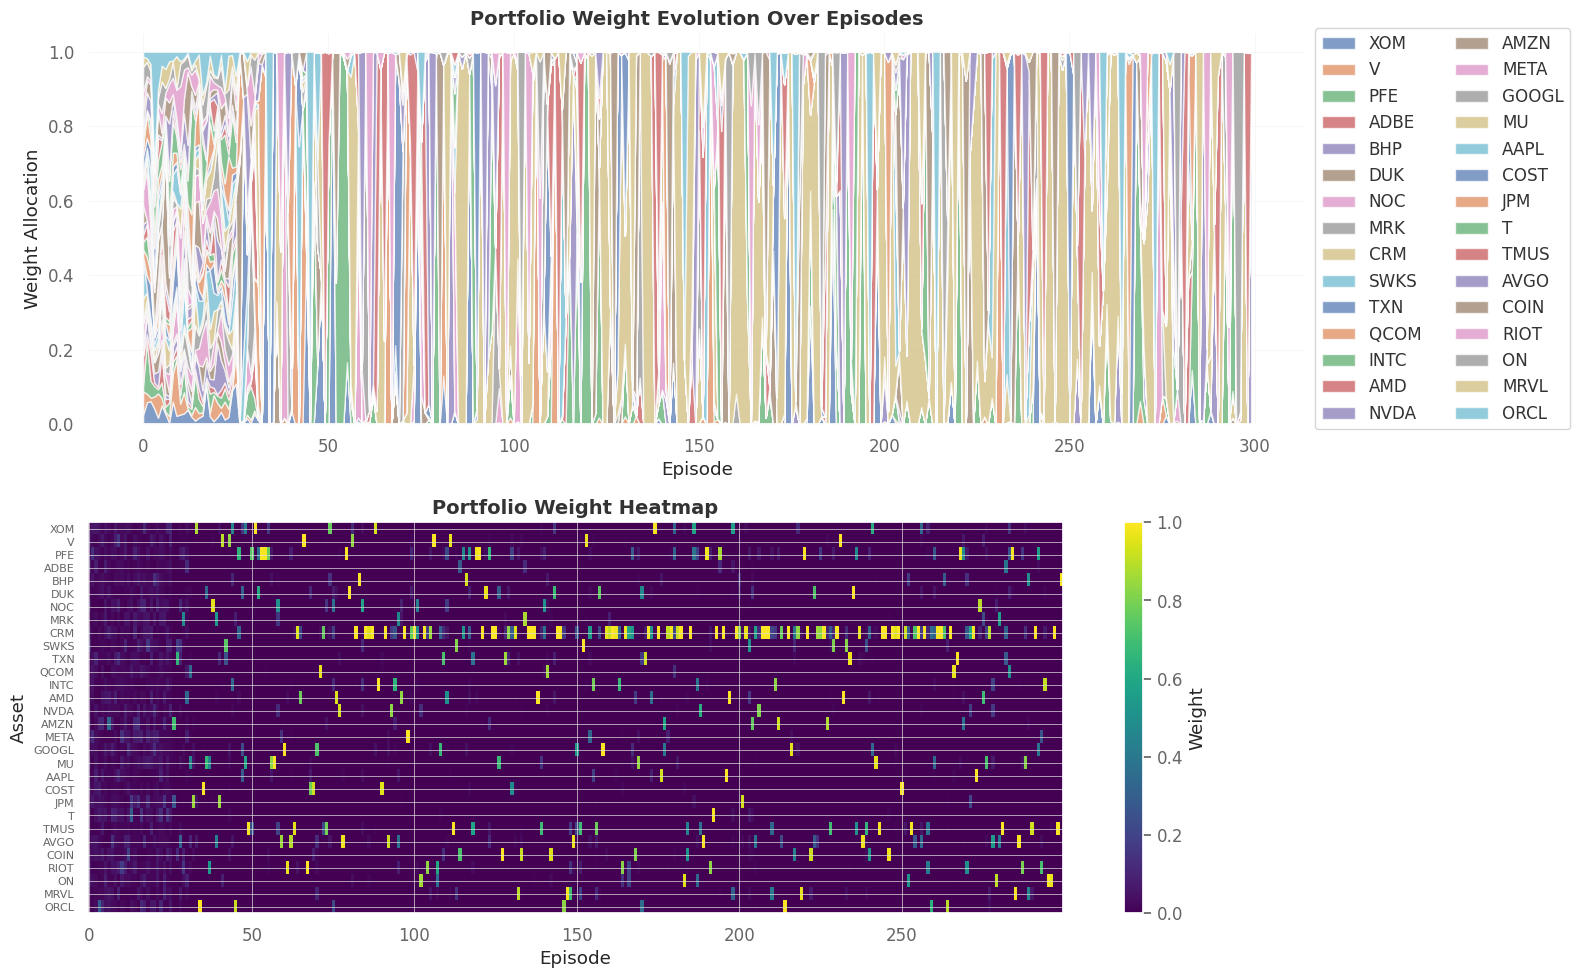

Portfolio weight visualizations saved to 'portfolio_weights.png'

Average weights (last 50 episodes):
XOM     : 0.0124 (1.24%)
V       : 0.0033 (0.33%)
PFE     : 0.0774 (7.74%)
ADBE    : 0.0084 (0.84%)
BHP     : 0.0419 (4.19%)
DUK     : 0.0050 (0.50%)
NOC     : 0.0196 (1.96%)
MRK     : 0.0160 (1.60%)
CRM     : 0.2846 (28.46%)
SWKS    : 0.0018 (0.18%)
TXN     : 0.0256 (2.56%)
QCOM    : 0.0292 (2.92%)
INTC    : 0.0231 (2.31%)
AMD     : 0.0150 (1.50%)
NVDA    : 0.0073 (0.73%)
AMZN    : 0.0083 (0.83%)
META    : 0.0052 (0.52%)
GOOGL   : 0.0081 (0.81%)
MU      : 0.0404 (4.04%)
AAPL    : 0.0208 (2.08%)
COST    : 0.0200 (2.00%)
JPM     : 0.0046 (0.46%)
T       : 0.0002 (0.02%)
TMUS    : 0.0889 (8.89%)
AVGO    : 0.0532 (5.32%)
COIN    : 0.0003 (0.03%)
RIOT    : 0.0484 (4.84%)
ON      : 0.0679 (6.79%)
MRVL    : 0.0318 (3.18%)
ORCL    : 0.0315 (3.15%)


In [34]:
# Cell 21: Visualize Final Portfolio Weights Evolution

if len(final_weights_history) > 0:
    weights_array = np.array(final_weights_history)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Stacked area plot
    axes[0].stackplot(range(len(final_weights_history)),
                      weights_array.T,
                      labels=portfolio_stocks,
                      alpha=0.7)
    axes[0].set_title('Portfolio Weight Evolution Over Episodes', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Weight Allocation')
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    axes[0].grid(True, alpha=0.3)

    # Heatmap
    im = axes[1].imshow(weights_array.T, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[1].set_title('Portfolio Weight Heatmap', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Asset')
    axes[1].set_yticks(range(len(portfolio_stocks)))
    axes[1].set_yticklabels(portfolio_stocks, fontsize=8)
    plt.colorbar(im, ax=axes[1], label='Weight')

    plt.tight_layout()
    plt.savefig('portfolio_weights.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Portfolio weight visualizations saved to 'portfolio_weights.png'")

    # Print final average weights
    final_avg_weights = weights_array[-50:].mean(axis=0)
    print("\nAverage weights (last 50 episodes):")
    for stock, weight in zip(portfolio_stocks, final_avg_weights):
        print(f"{stock:8s}: {weight:.4f} ({weight*100:.2f}%)")

In [35]:
# Cell 22: Test Evaluation Function

def run_sac_policy_on_test(test_env, agent, num_episodes=1, deterministic=True):
    """
    Run trained SAC policy on test environment
    """
    all_returns = []
    all_weights = []
    all_actions = []
    all_sharpe = []
    all_info = []

    for ep in range(num_episodes):
        state = test_env.reset()
        done = False
        episode_returns = []
        episode_weights = []
        episode_sharpe = []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

            with torch.no_grad():
                if deterministic:
                    action, _ = agent.actor.deterministic(state_tensor)
                else:
                    action, _ = agent.actor(state_tensor)

            action = action.cpu().numpy().flatten()
            next_state, reward, done, info = test_env.step(action)

            episode_returns.append(info['portfolio_return'])
            episode_weights.append(info['weights'])
            episode_sharpe.append(info.get('sharpe_like_reward', 0))
            all_info.append(info)

            state = next_state

        all_returns.extend(episode_returns)
        all_weights.extend(episode_weights)
        all_sharpe.extend(episode_sharpe)

    return {
        'returns': np.array(all_returns),
        'weights': np.array(all_weights),
        'sharpe': np.array(all_sharpe),
        'info': all_info
    }

# Run test evaluation
print("Evaluating trained agent on test set...")
test_results = run_sac_policy_on_test(test_env, agent, num_episodes=1, deterministic=True)

print(f"\nTest Results:")
print(f"Total returns: {len(test_results['returns'])}")
print(f"Mean return: {test_results['returns'].mean():.6f}")
print(f"Std return: {test_results['returns'].std():.6f}")
print(f"Sharpe (approx): {test_results['returns'].mean() / (test_results['returns'].std() + 1e-8):.4f}")
print(f"Cumulative return: {(1 + test_results['returns']).prod() - 1:.4f}")

Evaluating trained agent on test set...

Test Results:
Total returns: 169
Mean return: 0.001385
Std return: 0.019294
Sharpe (approx): 0.0718
Cumulative return: 0.2249


In [36]:
# Cell 23: Benchmark Portfolio Strategies

# Define benchmark portfolio strategies

def equal_weight_portfolio(returns_data):
    """Equal weight (1/N) portfolio"""
    n_assets = returns_data.shape[1]
    weights = np.ones(n_assets) / n_assets
    portfolio_returns = (returns_data * weights).sum(axis=1)
    return portfolio_returns, weights

def risk_parity_portfolio(returns_data, lookback=60):
    """Risk parity portfolio"""
    n_periods, n_assets = returns_data.shape
    portfolio_returns = []

    for i in range(n_periods):
        if i < lookback:
            # Use equal weights initially
            weights = np.ones(n_assets) / n_assets
        else:
            # Calculate covariance from lookback window
            window_returns = returns_data[max(0, i-lookback):i]
            cov_matrix = np.cov(window_returns.T)

            # Risk parity: inverse volatility weighting
            vols = np.sqrt(np.diag(cov_matrix))
            weights = (1 / vols) / (1 / vols).sum()

        portfolio_returns.append((returns_data[i] * weights).sum())

    return np.array(portfolio_returns), weights

def minimum_variance_portfolio(returns_data, lookback=60):
    """Minimum variance portfolio using CVXPY"""
    n_periods, n_assets = returns_data.shape
    portfolio_returns = []
    weights_history = []

    for i in range(n_periods):
        if i < lookback:
            weights = np.ones(n_assets) / n_assets
        else:
            window_returns = returns_data[max(0, i-lookback):i]
            cov_matrix = LedoitWolf().fit(window_returns).covariance_

            try:
                w = cp.Variable(n_assets)
                objective = cp.Minimize(cp.quad_form(w, cov_matrix))
                constraints = [cp.sum(w) == 1, w >= 0]
                problem = cp.Problem(objective, constraints)
                problem.solve()

                if w.value is not None:
                    weights = w.value
                else:
                    weights = np.ones(n_assets) / n_assets
            except:
                weights = np.ones(n_assets) / n_assets

        weights_history.append(weights)
        portfolio_returns.append((returns_data[i] * weights).sum())

    return np.array(portfolio_returns), np.array(weights_history)

# Calculate returns for test data
test_returns_data = np.diff(test_price_data, axis=0) / test_price_data[:-1]
test_returns_data = np.nan_to_num(test_returns_data)

print("Computing benchmark strategies...")

# Equal Weight
eq_returns, eq_weights = equal_weight_portfolio(test_returns_data)
print(f"Equal Weight - Mean: {eq_returns.mean():.6f}, Std: {eq_returns.std():.6f}")

# Risk Parity
rp_returns, rp_weights = risk_parity_portfolio(test_returns_data)
print(f"Risk Parity - Mean: {rp_returns.mean():.6f}, Std: {rp_returns.std():.6f}")

# Minimum Variance
mv_returns, mv_weights = minimum_variance_portfolio(test_returns_data)
print(f"Min Variance - Mean: {mv_returns.mean():.6f}, Std: {mv_returns.std():.6f}")

# SAC returns (already computed in test_results)
sac_returns = test_results['returns']
print(f"SAC Agent - Mean: {sac_returns.mean():.6f}, Std: {sac_returns.std():.6f}")

print("\nBenchmark portfolios computed successfully")

Computing benchmark strategies...
Equal Weight - Mean: 0.000904, Std: 0.014449
Risk Parity - Mean: 0.000650, Std: 0.011443
Min Variance - Mean: 0.000296, Std: 0.008556
SAC Agent - Mean: 0.001385, Std: 0.019294

Benchmark portfolios computed successfully


In [37]:
# Cell 24: Performance Metrics Calculation

def calculate_performance_metrics(returns, risk_free_rate=0.0442):
    """Calculate comprehensive performance metrics"""
    # Annualization factor
    periods_per_year = 252

    # Convert annual risk-free rate to daily
    rf_daily = (1 + risk_free_rate) ** (1 / periods_per_year) - 1

    # Basic statistics
    mean_return = returns.mean()
    std_return = returns.std()

    # Annualized metrics
    annualized_return = (1 + mean_return) ** periods_per_year - 1
    annualized_vol = std_return * np.sqrt(periods_per_year)

    # Sharpe Ratio
    sharpe = (mean_return - rf_daily) / std_return * np.sqrt(periods_per_year)

    # Sortino Ratio (downside deviation)
    downside_returns = returns[returns < 0]
    if len(downside_returns) > 0:
        downside_std = downside_returns.std()
        sortino = (mean_return - rf_daily) / downside_std * np.sqrt(periods_per_year)
    else:
        sortino = np.inf

    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Calmar Ratio
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.inf

    # Win Rate
    win_rate = (returns > 0).sum() / len(returns)

    # Value at Risk (95%)
    var_95 = np.percentile(returns, 5)

    # Conditional Value at Risk (CVaR/Expected Shortfall)
    cvar_95 = returns[returns <= var_95].mean()

    metrics = {
        'Mean Daily Return': mean_return,
        'Daily Volatility': std_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95,
        'Cumulative Return': cumulative[-1] - 1
    }

    return metrics

# Calculate metrics for all strategies
print("Calculating performance metrics...\n")

metrics_dict = {
    'SAC Agent': calculate_performance_metrics(sac_returns),
    'Equal Weight': calculate_performance_metrics(eq_returns),
    'Risk Parity': calculate_performance_metrics(rp_returns),
    'Min Variance': calculate_performance_metrics(mv_returns)
}

# Create comparison DataFrame
metrics_df = pd.DataFrame(metrics_dict).T

print("="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)
print(metrics_df.to_string())
print("="*80)

# Save metrics
metrics_df.to_csv('performance_metrics.csv')
print("\nMetrics saved to 'performance_metrics.csv'")

Calculating performance metrics...

PERFORMANCE METRICS COMPARISON
              Mean Daily Return  Daily Volatility  Annualized Return  Annualized Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Calmar Ratio  Win Rate  VaR (95%)  CVaR (95%)  Cumulative Return
SAC Agent              0.001385          0.019294           0.417197               0.306286      0.997981       1.898103     -0.198323      2.103620  0.514793  -0.027448   -0.035384           0.224943
Equal Weight           0.000904          0.014449           0.255624               0.229376      0.804273       1.084026     -0.240351      1.063545  0.576441  -0.024222   -0.033501           0.375841
Risk Parity            0.000650          0.011443           0.177836               0.181652      0.663234       0.853929     -0.195839      0.908074  0.576441  -0.016648   -0.027105           0.262583
Min Variance           0.000296          0.008556           0.077310               0.135815      0.229898       0.276991     -0.1

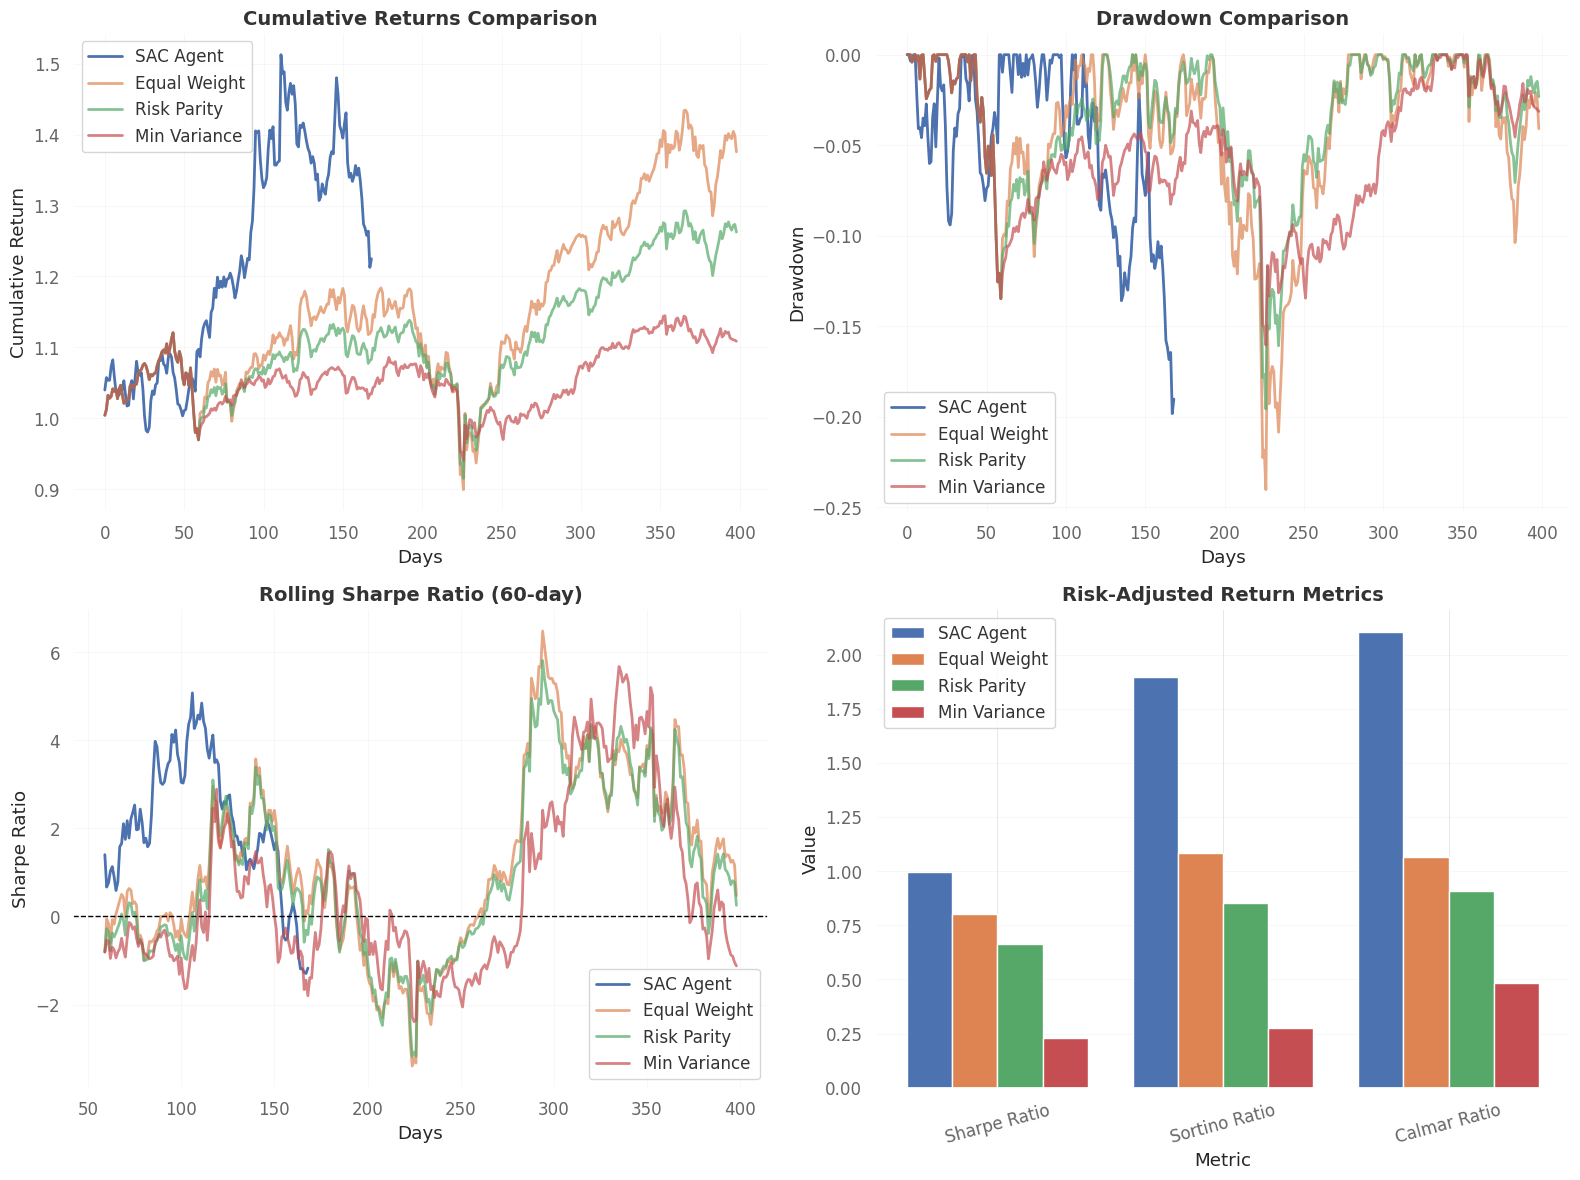

Final comparison visualizations saved to 'final_comparison.png'


In [38]:
# Cell 25: Final Comparison Visualizations

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative returns comparison
sac_cum = (1 + sac_returns).cumprod()
eq_cum = (1 + eq_returns).cumprod()
rp_cum = (1 + rp_returns).cumprod()
mv_cum = (1 + mv_returns).cumprod()

axes[0, 0].plot(sac_cum, label='SAC Agent', linewidth=2)
axes[0, 0].plot(eq_cum, label='Equal Weight', linewidth=2, alpha=0.7)
axes[0, 0].plot(rp_cum, label='Risk Parity', linewidth=2, alpha=0.7)
axes[0, 0].plot(mv_cum, label='Min Variance', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Cumulative Return')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Drawdown comparison
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    return (cumulative - running_max) / running_max

axes[0, 1].plot(calculate_drawdown(sac_returns), label='SAC Agent', linewidth=2)
axes[0, 1].plot(calculate_drawdown(eq_returns), label='Equal Weight', linewidth=2, alpha=0.7)
axes[0, 1].plot(calculate_drawdown(rp_returns), label='Risk Parity', linewidth=2, alpha=0.7)
axes[0, 1].plot(calculate_drawdown(mv_returns), label='Min Variance', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Drawdown')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rolling Sharpe Ratio (60-day window)
window = 60
rf_daily = (1 + 0.0442) ** (1/252) - 1

sac_rolling_sharpe = pd.Series(sac_returns).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
eq_rolling_sharpe = pd.Series(eq_returns).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
rp_rolling_sharpe = pd.Series(rp_returns).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
mv_rolling_sharpe = pd.Series(mv_returns).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)

axes[1, 0].plot(sac_rolling_sharpe, label='SAC Agent', linewidth=2)
axes[1, 0].plot(eq_rolling_sharpe, label='Equal Weight', linewidth=2, alpha=0.7)
axes[1, 0].plot(rp_rolling_sharpe, label='Risk Parity', linewidth=2, alpha=0.7)
axes[1, 0].plot(mv_rolling_sharpe, label='Min Variance', linewidth=2, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title(f'Rolling Sharpe Ratio ({window}-day)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bar chart of key metrics
metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, strategy in enumerate(['SAC Agent', 'Equal Weight', 'Risk Parity', 'Min Variance']):
    values = [metrics_dict[strategy][metric] for metric in metrics_to_plot]
    # Clip extreme values for visualization
    values = [min(v, 5) if not np.isinf(v) else 5 for v in values]
    axes[1, 1].bar(x + i*width, values, width, label=strategy)

axes[1, 1].set_title('Risk-Adjusted Return Metrics', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Metric')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x + width * 1.5)
axes[1, 1].set_xticklabels(metrics_to_plot, rotation=15)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Final comparison visualizations saved to 'final_comparison.png'")

In [39]:
# Cell 28: LSTM Return Predictor Baseline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Simple LSTM for return prediction
class LSTMReturnPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predict next-day return
        )

    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)
        # Take last time step
        last_output = lstm_out[:, -1, :]
        prediction = self.fc(last_output)
        return prediction

# Dataset for LSTM
class StockReturnDataset(Dataset):
    def __init__(self, price_data, feature_matrix, lookback=20):
        self.price_data = price_data
        self.feature_matrix = feature_matrix
        self.lookback = lookback
        self.n_assets = price_data.shape[1]

    def __len__(self):
        return (len(self.price_data) - self.lookback - 1) * self.n_assets

    def __getitem__(self, idx):
        # Determine which asset and time index
        asset_idx = idx % self.n_assets
        time_idx = idx // self.n_assets

        # Get feature sequence
        start_t = time_idx
        end_t = time_idx + self.lookback

        # Extract features for this asset
        asset_features = []
        for t in range(start_t, end_t):
            # Get asset-specific features (19 features per asset)
            asset_start = asset_idx * 19
            asset_end = asset_start + 19
            asset_features.append(self.feature_matrix[t, asset_start:asset_end])

        features = torch.FloatTensor(np.array(asset_features))

        # Calculate target return
        price_t = self.price_data[end_t, asset_idx]
        price_t1 = self.price_data[end_t + 1, asset_idx]
        target_return = (price_t1 - price_t) / price_t
        target = torch.FloatTensor([target_return])

        return features, target

print("LSTM Return Predictor defined")

LSTM Return Predictor defined


In [41]:
# Cell 28b: Diagnose Data Quality Before LSTM Training

print("="*70)
print("DATA QUALITY DIAGNOSTICS")
print("="*70)

# Check price data
print("\n1. Price Data:")
print(f"   Train shape: {train_price_data.shape}")
print(f"   Test shape: {test_price_data.shape}")
print(f"   Train NaN: {np.isnan(train_price_data).sum()}")
print(f"   Train Inf: {np.isinf(train_price_data).sum()}")
print(f"   Test NaN: {np.isnan(test_price_data).sum()}")
print(f"   Test Inf: {np.isinf(test_price_data).sum()}")

# Check feature matrix
print("\n2. Feature Matrix:")
print(f"   Train shape: {train_feature_matrix.shape}")
print(f"   Test shape: {test_feature_matrix.shape}")
print(f"   Train NaN: {np.isnan(train_feature_matrix).sum()}")
print(f"   Train Inf: {np.isinf(train_feature_matrix).sum()}")
print(f"   Test NaN: {np.isnan(test_feature_matrix).sum()}")
print(f"   Test Inf: {np.isinf(test_feature_matrix).sum()}")

# Check feature statistics
print("\n3. Feature Statistics:")
print(f"   Train mean: {train_feature_matrix.mean():.6f}")
print(f"   Train std: {train_feature_matrix.std():.6f}")
print(f"   Train min: {train_feature_matrix.min():.6f}")
print(f"   Train max: {train_feature_matrix.max():.6f}")

# If there are NaN or Inf, clean them
if np.isnan(train_price_data).any() or np.isinf(train_price_data).any():
    print("\n⚠️  WARNING: Cleaning train_price_data...")
    train_price_data = np.nan_to_num(train_price_data, nan=0.0, posinf=0.0, neginf=0.0)
    # Forward fill zeros with previous valid value
    for i in range(train_price_data.shape[1]):
        col = train_price_data[:, i]
        mask = col == 0
        if mask.any():
            valid_indices = np.where(~mask)[0]
            if len(valid_indices) > 0:
                col[mask] = np.interp(np.where(mask)[0], valid_indices, col[valid_indices])
    print("   ✓ Cleaned")

if np.isnan(test_price_data).any() or np.isinf(test_price_data).any():
    print("\n⚠️  WARNING: Cleaning test_price_data...")
    test_price_data = np.nan_to_num(test_price_data, nan=0.0, posinf=0.0, neginf=0.0)
    for i in range(test_price_data.shape[1]):
        col = test_price_data[:, i]
        mask = col == 0
        if mask.any():
            valid_indices = np.where(~mask)[0]
            if len(valid_indices) > 0:
                col[mask] = np.interp(np.where(mask)[0], valid_indices, col[valid_indices])
    print("   ✓ Cleaned")

if np.isnan(train_feature_matrix).any() or np.isinf(train_feature_matrix).any():
    print("\n⚠️  WARNING: Cleaning train_feature_matrix...")
    train_feature_matrix = np.nan_to_num(train_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
    print("   ✓ Cleaned")

if np.isnan(test_feature_matrix).any() or np.isinf(test_feature_matrix).any():
    print("\n⚠️  WARNING: Cleaning test_feature_matrix...")
    test_feature_matrix = np.nan_to_num(test_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
    print("   ✓ Cleaned")

# Test creating a sample from dataset
print("\n4. Testing Dataset Creation:")
try:
    lookback = 20
    test_ds = StockReturnDataset(train_price_data, train_feature_matrix, lookback=lookback)
    sample_feat, sample_tgt = test_ds[0]
    print(f"   Sample feature shape: {sample_feat.shape}")
    print(f"   Sample target shape: {sample_tgt.shape}")
    print(f"   Sample has NaN: {torch.isnan(sample_feat).any().item()} (features), {torch.isnan(sample_tgt).any().item()} (target)")
    print(f"   Sample feature range: [{sample_feat.min():.4f}, {sample_feat.max():.4f}]")
    print(f"   Sample target value: {sample_tgt.item():.6f}")
    print("   ✓ Dataset creation successful")
except Exception as e:
    print(f"   ✗ Error: {e}")

print("\n" + "="*70)
print("Data quality check complete. Proceed with LSTM training.")
print("="*70)

DATA QUALITY DIAGNOSTICS

1. Price Data:
   Train shape: (1599, 30)
   Test shape: (400, 30)
   Train NaN: 825
   Train Inf: 0
   Test NaN: 0
   Test Inf: 0

2. Feature Matrix:
   Train shape: (1599, 572)
   Test shape: (400, 572)
   Train NaN: 0
   Train Inf: 0
   Test NaN: 0
   Test Inf: 0

3. Feature Statistics:
   Train mean: 0.000000
   Train std: 1.000000
   Train min: -9.755840
   Train max: 8.500757

⚠️  WARNING: Cleaning train_price_data...
   ✓ Cleaned

4. Testing Dataset Creation:
   Sample feature shape: torch.Size([20, 19])
   Sample target shape: torch.Size([1])
   Sample has NaN: False (features), False (target)
   Sample feature range: [-3.8774, 1.6226]
   Sample target value: 0.020275
   ✓ Dataset creation successful

Data quality check complete. Proceed with LSTM training.


Checking dataset for NaN values...
Sample features NaN: False
Sample target NaN: False
Training samples: 47340
Test samples: 11370

LSTM Model Parameters: 59,265

Starting LSTM training...
Epoch 5/20 - Train Loss: 0.000724, Val Loss: 0.000778, LR: 0.000500
Epoch 10/20 - Train Loss: 0.000724, Val Loss: 0.000778, LR: 0.000250
Epoch 15/20 - Train Loss: 0.000723, Val Loss: 0.000778, LR: 0.000063
Epoch 20/20 - Train Loss: 0.000724, Val Loss: 0.000778, LR: 0.000031

LSTM training completed!
Best validation loss: 0.000778


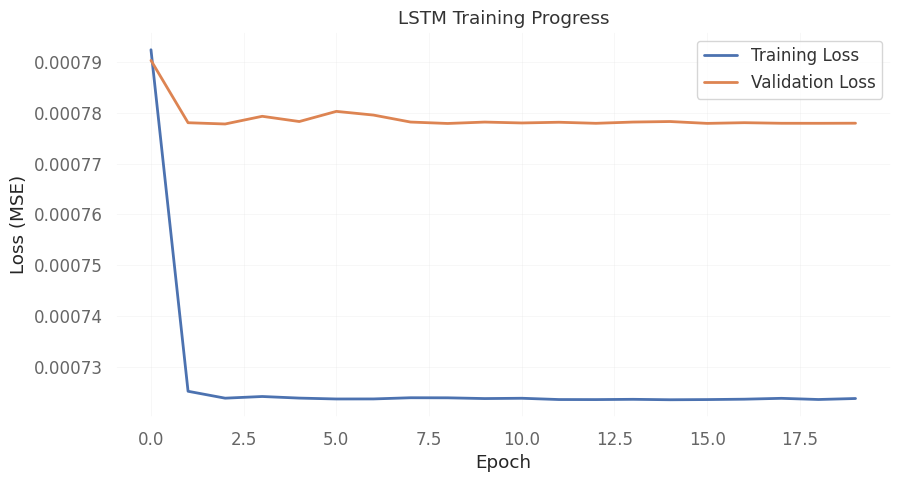

Training curve saved to 'lstm_training_curve.png'


In [42]:
# Cell 29: Train LSTM Baseline (FIXED - Stable Training)

# Create datasets
lookback = 20  # Use 20 days to predict next day
train_dataset = StockReturnDataset(train_price_data, train_feature_matrix, lookback=lookback)
test_dataset = StockReturnDataset(test_price_data, test_feature_matrix, lookback=lookback)

# Check for NaN in dataset
print("Checking dataset for NaN values...")
sample_features, sample_target = train_dataset[0]
print(f"Sample features NaN: {torch.isnan(sample_features).any()}")
print(f"Sample target NaN: {torch.isnan(sample_target).any()}")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize model with better initialization
input_size = 19  # Asset features per time step
lstm_model = LSTMReturnPredictor(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2).to(device)

# Initialize weights properly
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

lstm_model.apply(init_weights)

# Use smaller learning rate and add scheduler
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.MSELoss()  # Use MSE instead of Huber for stability

print(f"\nLSTM Model Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Training loop with better error handling
num_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("\nStarting LSTM training...")

for epoch in range(num_epochs):
    # Training
    lstm_model.train()
    epoch_loss = 0
    batch_count = 0

    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)

        # Check for NaN in batch
        if torch.isnan(features).any() or torch.isnan(targets).any():
            print(f"Warning: NaN detected in batch, skipping...")
            continue

        optimizer.zero_grad()
        predictions = lstm_model(features)

        # Clip predictions to reasonable range
        predictions = torch.clamp(predictions, -0.5, 0.5)
        targets = torch.clamp(targets, -0.5, 0.5)

        loss = criterion(predictions, targets)

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"Warning: NaN loss detected, skipping batch...")
            continue

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    if batch_count == 0:
        print(f"Epoch {epoch+1}: No valid batches!")
        break

    avg_train_loss = epoch_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation
    lstm_model.eval()
    val_loss = 0
    val_batch_count = 0

    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)

            if torch.isnan(features).any() or torch.isnan(targets).any():
                continue

            predictions = lstm_model(features)
            predictions = torch.clamp(predictions, -0.5, 0.5)
            targets = torch.clamp(targets, -0.5, 0.5)

            loss = criterion(predictions, targets)

            if not torch.isnan(loss):
                val_loss += loss.item()
                val_batch_count += 1

    if val_batch_count == 0:
        print(f"Epoch {epoch+1}: No valid validation batches!")
        continue

    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(lstm_model.state_dict(), 'lstm_return_predictor_best.pth')

    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.6f}")

print("\nLSTM training completed!")

# Load best model
lstm_model.load_state_dict(torch.load('lstm_return_predictor_best.pth'))
print(f"Best validation loss: {best_val_loss:.6f}")

# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Training Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('LSTM Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('lstm_training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curve saved to 'lstm_training_curve.png'")

In [43]:
# Cell 30: Generate LSTM-Based Portfolio

# Function to predict returns for all assets at each time step
def predict_returns_lstm(model, price_data, feature_matrix, lookback=20):
    """Predict returns for all assets at each time step"""
    model.eval()
    n_periods = len(price_data) - lookback
    n_assets = price_data.shape[1]

    all_predictions = []

    with torch.no_grad():
        for t in range(lookback, len(feature_matrix)):
            period_predictions = []

            for asset_idx in range(n_assets):
                # Extract sequence for this asset
                asset_features = []
                for past_t in range(t - lookback, t):
                    asset_start = asset_idx * 19
                    asset_end = asset_start + 19
                    asset_features.append(feature_matrix[past_t, asset_start:asset_end])

                features = torch.FloatTensor(np.array(asset_features)).unsqueeze(0).to(device)
                pred = model(features).cpu().item()
                period_predictions.append(pred)

            all_predictions.append(period_predictions)

    return np.array(all_predictions)

# Predict returns for test set
print("Generating LSTM predictions for test set...")
lstm_predicted_returns = predict_returns_lstm(
    lstm_model,
    test_price_data,
    test_feature_matrix,
    lookback=lookback
)

print(f"Predicted returns shape: {lstm_predicted_returns.shape}")
print(f"Mean predicted return: {lstm_predicted_returns.mean():.6f}")
print(f"Std predicted return: {lstm_predicted_returns.std():.6f}")

# Optimize portfolio using predicted returns (Sharpe maximization)
def optimize_portfolio_sharpe(predicted_returns, risk_free_rate=0.0442):
    """Optimize portfolio weights using predicted returns"""
    n_periods, n_assets = predicted_returns.shape
    portfolio_returns = []
    portfolio_weights = []

    for t in range(n_periods - 1):
        expected_returns = predicted_returns[t]

        # Get historical returns for covariance estimation (use 60-day window)
        lookback_cov = 60
        start_idx = max(0, t - lookback_cov)
        if start_idx + lookback_cov < t:
            historical_prices = test_price_data[start_idx:t]
            if len(historical_prices) > 2:
                returns_hist = np.diff(historical_prices, axis=0) / historical_prices[:-1]
                returns_hist = np.nan_to_num(returns_hist, 0)
                cov_matrix = LedoitWolf().fit(returns_hist).covariance_
            else:
                cov_matrix = np.eye(n_assets) * 0.01
        else:
            cov_matrix = np.eye(n_assets) * 0.01

        try:
            # Sharpe optimization
            w = cp.Variable(n_assets)
            daily_rf = (1 + risk_free_rate) ** (1/252) - 1

            # Maximize Sharpe: (return - rf) / sqrt(variance)
            portfolio_return = expected_returns @ w
            portfolio_variance = cp.quad_form(w, cov_matrix)

            # Approximate Sharpe by maximizing return and minimizing variance
            objective = cp.Maximize(portfolio_return - 0.5 * portfolio_variance)
            constraints = [cp.sum(w) == 1, w >= 0]

            problem = cp.Problem(objective, constraints)
            problem.solve(solver=cp.OSQP, verbose=False)

            if w.value is not None:
                weights = np.clip(w.value, 0, 1)
                weights = weights / weights.sum()
            else:
                weights = np.ones(n_assets) / n_assets
        except:
            weights = np.ones(n_assets) / n_assets

        # Calculate actual return
        actual_prices_t = test_price_data[lookback + t]
        actual_prices_t1 = test_price_data[lookback + t + 1]
        actual_returns = (actual_prices_t1 - actual_prices_t) / actual_prices_t
        actual_returns = np.nan_to_num(actual_returns, 0)

        portfolio_return = np.dot(weights, actual_returns)
        portfolio_returns.append(portfolio_return)
        portfolio_weights.append(weights)

    return np.array(portfolio_returns), np.array(portfolio_weights)

print("\nOptimizing LSTM-based portfolio...")
lstm_portfolio_returns, lstm_portfolio_weights = optimize_portfolio_sharpe(lstm_predicted_returns)

print(f"\nLSTM Portfolio Results:")
print(f"Number of trading days: {len(lstm_portfolio_returns)}")
print(f"Mean return: {lstm_portfolio_returns.mean():.6f}")
print(f"Std return: {lstm_portfolio_returns.std():.6f}")
print(f"Sharpe (approx): {lstm_portfolio_returns.mean() / (lstm_portfolio_returns.std() + 1e-8):.4f}")
print(f"Cumulative return: {(1 + lstm_portfolio_returns).prod() - 1:.4f}")

# Save results
np.save('lstm_portfolio_returns.npy', lstm_portfolio_returns)
np.save('lstm_portfolio_weights.npy', lstm_portfolio_weights)
print("\nLSTM portfolio results saved")

Generating LSTM predictions for test set...
Predicted returns shape: (380, 30)
Mean predicted return: 0.001008
Std predicted return: 0.000758

Optimizing LSTM-based portfolio...

LSTM Portfolio Results:
Number of trading days: 379
Mean return: 0.001050
Std return: 0.018513
Sharpe (approx): 0.0567
Cumulative return: 0.3958

LSTM portfolio results saved


In [44]:
# Cell 31: Updated Performance Comparison (with LSTM Baseline)

# Ensure all returns are aligned in length
min_length = min(len(sac_returns), len(eq_returns), len(rp_returns),
                 len(mv_returns), len(lstm_portfolio_returns))

sac_returns_aligned = sac_returns[:min_length]
eq_returns_aligned = eq_returns[:min_length]
rp_returns_aligned = rp_returns[:min_length]
mv_returns_aligned = mv_returns[:min_length]
lstm_returns_aligned = lstm_portfolio_returns[:min_length]

print(f"Aligned returns length: {min_length}")

# Recalculate metrics including LSTM
metrics_dict_updated = {
    'SAC Agent': calculate_performance_metrics(sac_returns_aligned),
    'LSTM-Sharpe': calculate_performance_metrics(lstm_returns_aligned),
    'Equal Weight': calculate_performance_metrics(eq_returns_aligned),
    'Risk Parity': calculate_performance_metrics(rp_returns_aligned),
    'Min Variance': calculate_performance_metrics(mv_returns_aligned)
}

# Create updated comparison DataFrame
metrics_df_updated = pd.DataFrame(metrics_dict_updated).T

print("="*90)
print("UPDATED PERFORMANCE METRICS COMPARISON (Including LSTM Baseline)")
print("="*90)
print(metrics_df_updated.to_string())
print("="*90)

# Save updated metrics
metrics_df_updated.to_csv('performance_metrics_with_lstm.csv')
print("\nUpdated metrics saved to 'performance_metrics_with_lstm.csv'")

# Highlight best performers
print("\n" + "="*90)
print("BEST PERFORMERS BY METRIC")
print("="*90)
for metric in ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Cumulative Return']:
    best = metrics_df_updated[metric].idxmax()
    value = metrics_df_updated.loc[best, metric]
    print(f"{metric:25s}: {best:15s} ({value:.4f})")

Aligned returns length: 169
UPDATED PERFORMANCE METRICS COMPARISON (Including LSTM Baseline)
              Mean Daily Return  Daily Volatility  Annualized Return  Annualized Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Calmar Ratio  Win Rate  VaR (95%)  CVaR (95%)  Cumulative Return
SAC Agent              0.001385          0.019294           0.417197               0.306286      0.997981       1.898103     -0.198323      2.103620  0.514793  -0.027448   -0.035384           0.224943
LSTM-Sharpe            0.000338          0.014612           0.089026               0.231959      0.181255       0.248278     -0.162137      0.549083  0.538462  -0.022830   -0.034348           0.039849
Equal Weight           0.000767          0.012450           0.213075               0.197643      0.758830       1.079865     -0.134850      1.580084  0.579882  -0.021278   -0.029340           0.123483
Risk Parity            0.000525          0.010121           0.141517               0.160658      0.5548

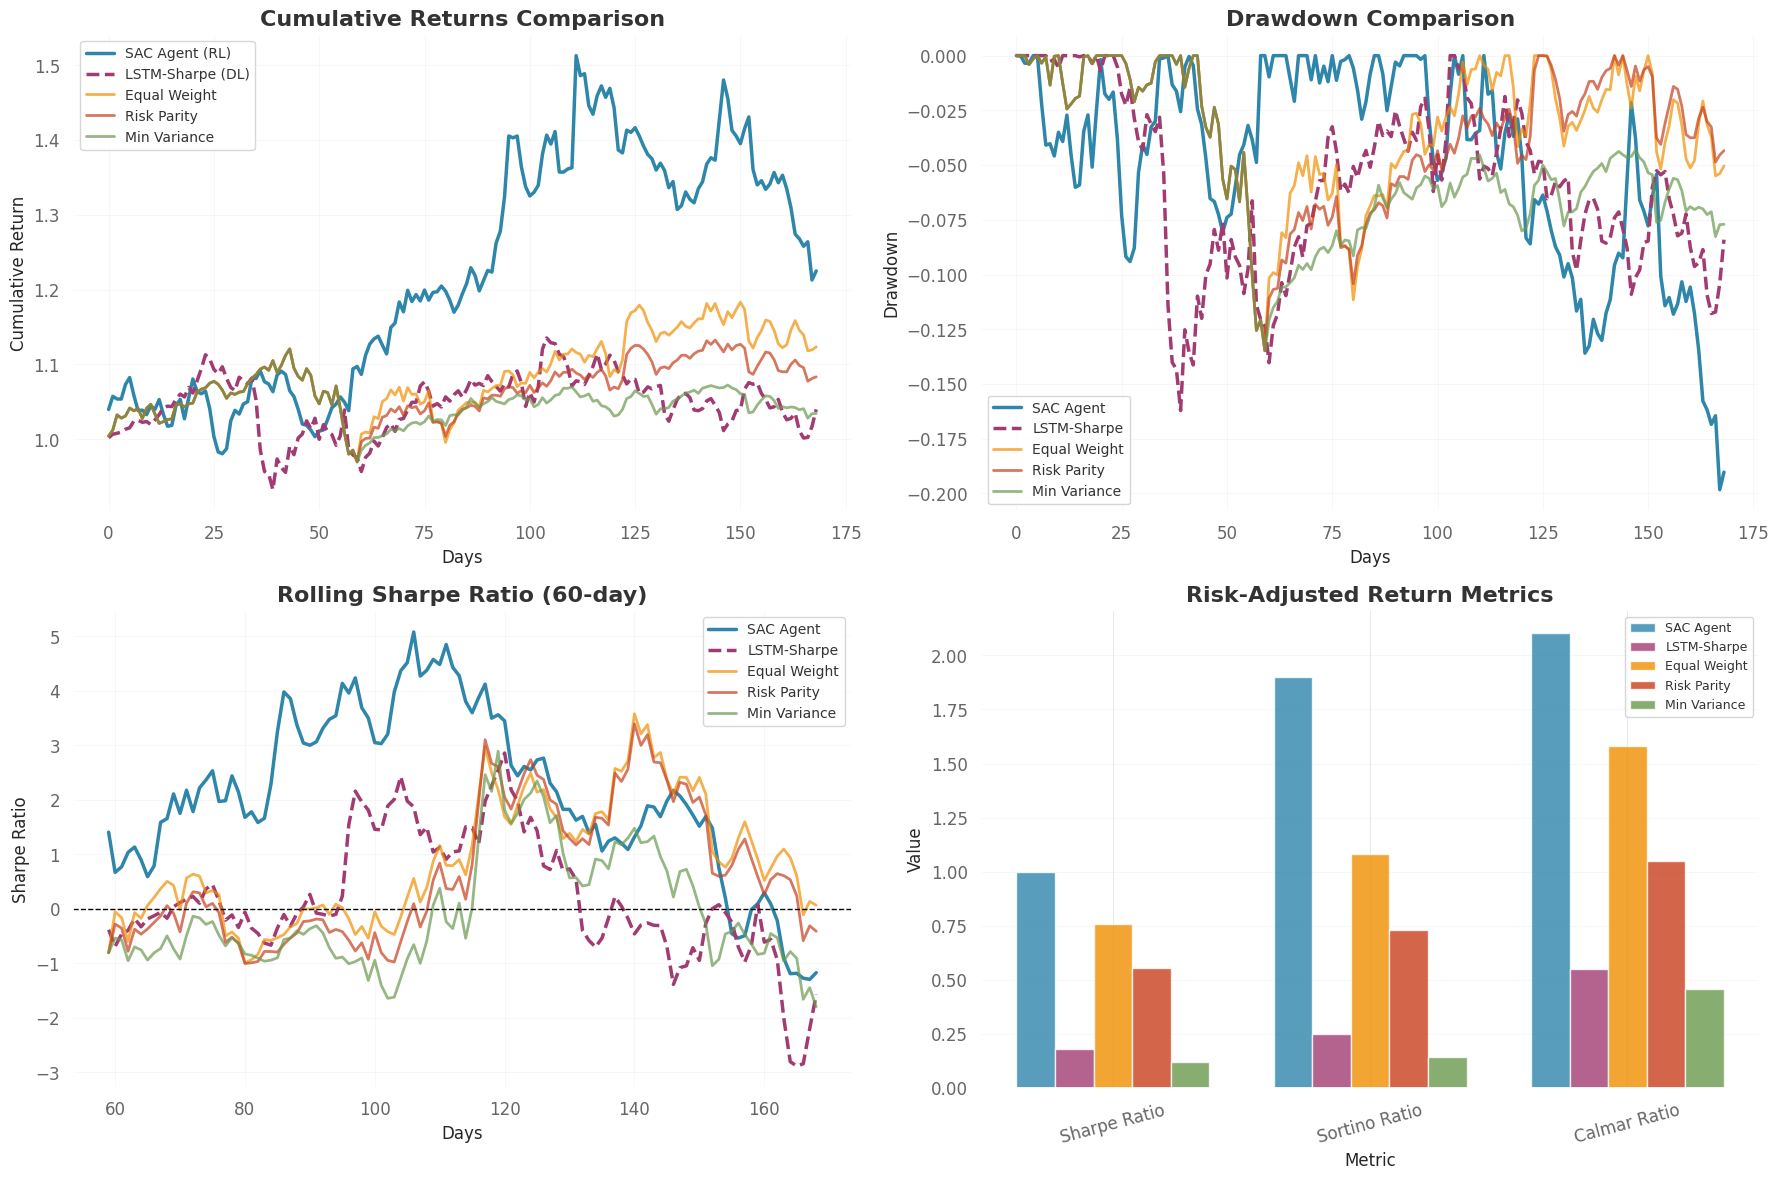

Final comparison (with LSTM) saved to 'final_comparison_with_lstm.png'


In [45]:
# Cell 32: Final Comparison Visualization (with LSTM)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Cumulative returns comparison
sac_cum = (1 + sac_returns_aligned).cumprod()
lstm_cum = (1 + lstm_returns_aligned).cumprod()
eq_cum = (1 + eq_returns_aligned).cumprod()
rp_cum = (1 + rp_returns_aligned).cumprod()
mv_cum = (1 + mv_returns_aligned).cumprod()

axes[0, 0].plot(sac_cum, label='SAC Agent (RL)', linewidth=2.5, color='#2E86AB')
axes[0, 0].plot(lstm_cum, label='LSTM-Sharpe (DL)', linewidth=2.5, color='#A23B72', linestyle='--')
axes[0, 0].plot(eq_cum, label='Equal Weight', linewidth=2, alpha=0.7, color='#F18F01')
axes[0, 0].plot(rp_cum, label='Risk Parity', linewidth=2, alpha=0.7, color='#C73E1D')
axes[0, 0].plot(mv_cum, label='Min Variance', linewidth=2, alpha=0.7, color='#6A994E')
axes[0, 0].set_title('Cumulative Returns Comparison', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Days', fontsize=12)
axes[0, 0].set_ylabel('Cumulative Return', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Drawdown comparison
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    return (cumulative - running_max) / running_max

axes[0, 1].plot(calculate_drawdown(sac_returns_aligned), label='SAC Agent', linewidth=2.5, color='#2E86AB')
axes[0, 1].plot(calculate_drawdown(lstm_returns_aligned), label='LSTM-Sharpe', linewidth=2.5, color='#A23B72', linestyle='--')
axes[0, 1].plot(calculate_drawdown(eq_returns_aligned), label='Equal Weight', linewidth=2, alpha=0.7, color='#F18F01')
axes[0, 1].plot(calculate_drawdown(rp_returns_aligned), label='Risk Parity', linewidth=2, alpha=0.7, color='#C73E1D')
axes[0, 1].plot(calculate_drawdown(mv_returns_aligned), label='Min Variance', linewidth=2, alpha=0.7, color='#6A994E')
axes[0, 1].set_title('Drawdown Comparison', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Days', fontsize=12)
axes[0, 1].set_ylabel('Drawdown', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Rolling Sharpe Ratio (60-day window)
window = 60
rf_daily = (1 + 0.0442) ** (1/252) - 1

sac_rolling_sharpe = pd.Series(sac_returns_aligned).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
lstm_rolling_sharpe = pd.Series(lstm_returns_aligned).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
eq_rolling_sharpe = pd.Series(eq_returns_aligned).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
rp_rolling_sharpe = pd.Series(rp_returns_aligned).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)
mv_rolling_sharpe = pd.Series(mv_returns_aligned).rolling(window).apply(
    lambda x: (x.mean() - rf_daily) / x.std() * np.sqrt(252)
)

axes[1, 0].plot(sac_rolling_sharpe, label='SAC Agent', linewidth=2.5, color='#2E86AB')
axes[1, 0].plot(lstm_rolling_sharpe, label='LSTM-Sharpe', linewidth=2.5, color='#A23B72', linestyle='--')
axes[1, 0].plot(eq_rolling_sharpe, label='Equal Weight', linewidth=2, alpha=0.7, color='#F18F01')
axes[1, 0].plot(rp_rolling_sharpe, label='Risk Parity', linewidth=2, alpha=0.7, color='#C73E1D')
axes[1, 0].plot(mv_rolling_sharpe, label='Min Variance', linewidth=2, alpha=0.7, color='#6A994E')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title(f'Rolling Sharpe Ratio ({window}-day)', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Days', fontsize=12)
axes[1, 0].set_ylabel('Sharpe Ratio', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bar chart of key metrics
metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
strategies = ['SAC Agent', 'LSTM-Sharpe', 'Equal Weight', 'Risk Parity', 'Min Variance']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

x = np.arange(len(metrics_to_plot))
width = 0.15

for i, strategy in enumerate(strategies):
    values = [metrics_dict_updated[strategy][metric] for metric in metrics_to_plot]
    # Clip extreme values for visualization
    values = [min(v, 5) if not np.isinf(v) else 5 for v in values]
    axes[1, 1].bar(x + i*width, values, width, label=strategy, color=colors[i], alpha=0.8)

axes[1, 1].set_title('Risk-Adjusted Return Metrics', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Metric', fontsize=12)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_xticks(x + width * 2)
axes[1, 1].set_xticklabels(metrics_to_plot, rotation=15)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_comparison_with_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Final comparison (with LSTM) saved to 'final_comparison_with_lstm.png'")

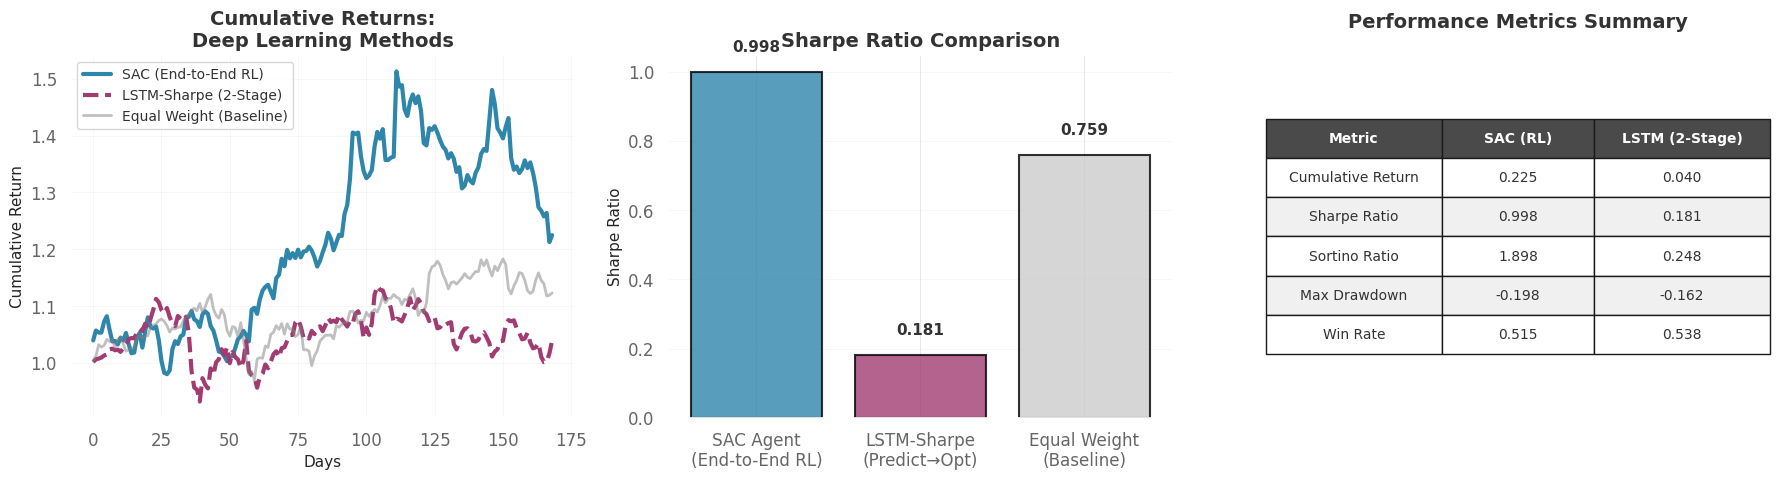

Deep Learning methods comparison saved to 'dl_methods_comparison.png'

DEEP LEARNING METHODS COMPARISON

SAC (End-to-End RL):        Sharpe = 0.9980
LSTM (Predict→Optimize):    Sharpe = 0.1813

✓ SAC outperforms LSTM by 450.6% in Sharpe Ratio

Conclusion: End-to-end RL approach is superior for sequential decision-making


In [46]:
# Cell 33: Deep Learning Methods Comparison

# Create a focused comparison between DL methods (SAC vs LSTM)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Method 1: SAC (End-to-End RL)
# Method 2: LSTM (Prediction → Optimization)

# Cumulative returns - DL methods only
axes[0].plot(sac_cum, label='SAC (End-to-End RL)', linewidth=3, color='#2E86AB')
axes[0].plot(lstm_cum, label='LSTM-Sharpe (2-Stage)', linewidth=3, color='#A23B72', linestyle='--')
axes[0].plot(eq_cum, label='Equal Weight (Baseline)', linewidth=2, color='gray', alpha=0.5)
axes[0].set_title('Cumulative Returns:\nDeep Learning Methods', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days', fontsize=11)
axes[0].set_ylabel('Cumulative Return', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Sharpe ratio comparison
dl_methods = ['SAC Agent\n(End-to-End RL)', 'LSTM-Sharpe\n(Predict→Opt)', 'Equal Weight\n(Baseline)']
sharpe_values = [
    metrics_dict_updated['SAC Agent']['Sharpe Ratio'],
    metrics_dict_updated['LSTM-Sharpe']['Sharpe Ratio'],
    metrics_dict_updated['Equal Weight']['Sharpe Ratio']
]

bars = axes[1].bar(dl_methods, sharpe_values, color=['#2E86AB', '#A23B72', '#CCCCCC'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sharpe Ratio', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels on bars
for bar, val in zip(bars, sharpe_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Summary statistics table
summary_data = {
    'Metric': ['Cumulative Return', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Win Rate'],
    'SAC (RL)': [
        f"{metrics_dict_updated['SAC Agent']['Cumulative Return']:.3f}",
        f"{metrics_dict_updated['SAC Agent']['Sharpe Ratio']:.3f}",
        f"{metrics_dict_updated['SAC Agent']['Sortino Ratio']:.3f}",
        f"{metrics_dict_updated['SAC Agent']['Max Drawdown']:.3f}",
        f"{metrics_dict_updated['SAC Agent']['Win Rate']:.3f}"
    ],
    'LSTM (2-Stage)': [
        f"{metrics_dict_updated['LSTM-Sharpe']['Cumulative Return']:.3f}",
        f"{metrics_dict_updated['LSTM-Sharpe']['Sharpe Ratio']:.3f}",
        f"{metrics_dict_updated['LSTM-Sharpe']['Sortino Ratio']:.3f}",
        f"{metrics_dict_updated['LSTM-Sharpe']['Max Drawdown']:.3f}",
        f"{metrics_dict_updated['LSTM-Sharpe']['Win Rate']:.3f}"
    ]
}

summary_df = pd.DataFrame(summary_data)

# Hide axis for table
axes[2].axis('tight')
axes[2].axis('off')

table = axes[2].table(cellText=summary_df.values,
                      colLabels=summary_df.columns,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.35, 0.3, 0.35])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#4A4A4A')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F0F0F0')

axes[2].set_title('Performance Metrics Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('dl_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Deep Learning methods comparison saved to 'dl_methods_comparison.png'")

# Print winner
print("\n" + "="*70)
print("DEEP LEARNING METHODS COMPARISON")
print("="*70)

sac_sharpe = metrics_dict_updated['SAC Agent']['Sharpe Ratio']
lstm_sharpe = metrics_dict_updated['LSTM-Sharpe']['Sharpe Ratio']

print(f"\nSAC (End-to-End RL):        Sharpe = {sac_sharpe:.4f}")
print(f"LSTM (Predict→Optimize):    Sharpe = {lstm_sharpe:.4f}")

if sac_sharpe > lstm_sharpe:
    improvement = ((sac_sharpe - lstm_sharpe) / abs(lstm_sharpe)) * 100
    print(f"\n✓ SAC outperforms LSTM by {improvement:.1f}% in Sharpe Ratio")
    print("\nConclusion: End-to-end RL approach is superior for sequential decision-making")
else:
    improvement = ((lstm_sharpe - sac_sharpe) / abs(sac_sharpe)) * 100
    print(f"\n✓ LSTM outperforms SAC by {improvement:.1f}% in Sharpe Ratio")
    print("\nConclusion: Prediction-based approach is more stable")

print("="*70)

In [47]:
# Cell 34: Transformer Return Predictor Baseline

import torch
import torch.nn as nn

class TransformerReturnPredictor(nn.Module):
    def __init__(self, input_size=19, d_model=64, nhead=4,
                 num_layers=2, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.d_model = d_model

        # Project features to d_model
        self.proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)   # scalar next-day return
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.proj(x)                  # (B, T, d_model)
        h = self.encoder(x)               # (B, T, d_model)
        last = h[:, -1, :]                # use last time step
        out = self.head(last)             # (B, 1)
        return out

print("TransformerReturnPredictor defined")

TransformerReturnPredictor defined


In [48]:
# Cell 35: Train Transformer Baseline

from torch.utils.data import DataLoader

lookback = 20
train_dataset_tr = StockReturnDataset(train_price_data, train_feature_matrix, lookback=lookback)
test_dataset_tr  = StockReturnDataset(test_price_data,  test_feature_matrix,  lookback=lookback)

train_loader_tr = DataLoader(train_dataset_tr, batch_size=128, shuffle=True)
test_loader_tr  = DataLoader(test_dataset_tr,  batch_size=128, shuffle=False)

print(f"Transformer | Training samples: {len(train_dataset_tr)}")
print(f"Transformer | Test samples: {len(test_dataset_tr)}")

transformer_model = TransformerReturnPredictor(input_size=19).to(device)

optimizer_tr = torch.optim.AdamW(transformer_model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_tr = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tr, mode='min', factor=0.5, patience=3
)
criterion_tr = nn.MSELoss()

print(f"\nTransformer Model Parameters: {sum(p.numel() for p in transformer_model.parameters()):,}")

num_epochs_tr = 15
train_losses_tr, val_losses_tr = [], []
best_val_tr = float("inf")

print("\nStarting Transformer training...")

for epoch in range(num_epochs_tr):
    # ---- Train ----
    transformer_model.train()
    epoch_loss, n_batches = 0.0, 0

    for features, targets in train_loader_tr:
        features, targets = features.to(device), targets.to(device)

        if torch.isnan(features).any() or torch.isnan(targets).any():
            continue

        optimizer_tr.zero_grad()
        preds = transformer_model(features)

        preds = torch.clamp(preds, -0.5, 0.5)
        targets = torch.clamp(targets, -0.5, 0.5)

        loss = criterion_tr(preds, targets)
        if torch.isnan(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        optimizer_tr.step()

        epoch_loss += loss.item()
        n_batches += 1

    if n_batches == 0:
        print(f"Epoch {epoch+1}: no valid train batches"); break

    avg_train = epoch_loss / n_batches
    train_losses_tr.append(avg_train)

    # ---- Validation ----
    transformer_model.eval()
    val_loss, n_val_batches = 0.0, 0

    with torch.no_grad():
        for features, targets in test_loader_tr:
            features, targets = features.to(device), targets.to(device)
            if torch.isnan(features).any() or torch.isnan(targets).any():
                continue

            preds = transformer_model(features)
            preds = torch.clamp(preds, -0.5, 0.5)
            targets = torch.clamp(targets, -0.5, 0.5)
            loss = criterion_tr(preds, targets)

            if not torch.isnan(loss):
                val_loss += loss.item()
                n_val_batches += 1

    if n_val_batches == 0:
        print(f"Epoch {epoch+1}: no valid val batches"); continue

    avg_val = val_loss / n_val_batches
    val_losses_tr.append(avg_val)

    scheduler_tr.step(avg_val)

    if avg_val < best_val_tr:
        best_val_tr = avg_val
        torch.save(transformer_model.state_dict(), "transformer_return_predictor_best.pth")

    if (epoch + 1) % 5 == 0:
        lr = optimizer_tr.param_groups[0]["lr"]
        print(f"Epoch {epoch+1}/{num_epochs_tr} - Train: {avg_train:.6f}, Val: {avg_val:.6f}, LR: {lr:.6f}")

print("\nTransformer training completed!")
transformer_model.load_state_dict(torch.load("transformer_return_predictor_best.pth"))
print(f"Best validation loss: {best_val_tr:.6f}")

Transformer | Training samples: 47340
Transformer | Test samples: 11370

Transformer Model Parameters: 72,449

Starting Transformer training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 5/15 - Train: 0.000726, Val: 0.001236, LR: 0.000500
Epoch 10/15 - Train: 0.000725, Val: 0.001118, LR: 0.000500
Epoch 15/15 - Train: 0.000724, Val: 0.001012, LR: 0.000250

Transformer training completed!
Best validation loss: 0.001012


In [49]:
# Cell 36: Transformer-Based Portfolio + Updated Metrics

def predict_returns_transformer(model, price_data, feature_matrix, lookback=20):
    model.eval()
    n_periods = len(price_data) - lookback
    n_assets = price_data.shape[1]
    all_preds = []

    with torch.no_grad():
        for t in range(lookback, len(feature_matrix)):
            period_preds = []
            for asset_idx in range(n_assets):
                seq_feats = []
                for past_t in range(t - lookback, t):
                    s = asset_idx * 19
                    e = s + 19
                    seq_feats.append(feature_matrix[past_t, s:e])
                feats = torch.FloatTensor(seq_feats).unsqueeze(0).to(device)
                pred = model(feats).cpu().item()
                period_preds.append(pred)
            all_preds.append(period_preds)

    return np.array(all_preds)

print("Predicting with Transformer on test set...")
transformer_pred_returns = predict_returns_transformer(
    transformer_model, test_price_data, test_feature_matrix, lookback=20
)

print(f"Transformer predicted returns shape: {transformer_pred_returns.shape}")

# Reuse same optimizer as for LSTM baseline
transformer_portfolio_returns, transformer_portfolio_weights = optimize_portfolio_sharpe(
    transformer_pred_returns
)

print("\nTransformer Portfolio Results:")
print(f"Days: {len(transformer_portfolio_returns)}")
print(f"Mean: {transformer_portfolio_returns.mean():.6f}")
print(f"Std: {transformer_portfolio_returns.std():.6f}")
print(f"Sharpe (approx): {transformer_portfolio_returns.mean() / (transformer_portfolio_returns.std()+1e-8):.4f}")
print(f"Cumulative: {(1 + transformer_portfolio_returns).prod() - 1:.4f}")

np.save("transformer_portfolio_returns.npy", transformer_portfolio_returns)
np.save("transformer_portfolio_weights.npy", transformer_portfolio_weights)

# ---- Update metrics table (building on Cells 31–33) ----

min_len = min(
    len(sac_returns),
    len(eq_returns),
    len(rp_returns),
    len(mv_returns),
    len(lstm_portfolio_returns),
    len(transformer_portfolio_returns),
)

sac_r   = sac_returns[:min_len]
eq_r    = eq_returns[:min_len]
rp_r    = rp_returns[:min_len]
mv_r    = mv_returns[:min_len]
lstm_r  = lstm_portfolio_returns[:min_len]
tr_r    = transformer_portfolio_returns[:min_len]

metrics_with_tr = {
    "SAC Agent":      calculate_performance_metrics(sac_r),
    "LSTM-Sharpe":    calculate_performance_metrics(lstm_r),
    "Transformer-Sharpe": calculate_performance_metrics(tr_r),
    "Equal Weight":   calculate_performance_metrics(eq_r),
    "Risk Parity":    calculate_performance_metrics(rp_r),
    "Min Variance":   calculate_performance_metrics(mv_r),
}

metrics_df_tr = pd.DataFrame(metrics_with_tr).T
metrics_df_tr.to_csv("performance_metrics_with_lstm_transformer.csv")

print("\n================ UPDATED METRICS (SAC vs LSTM vs Transformer) ================")
print(metrics_df_tr.to_string())
print("=============================================================================")

Predicting with Transformer on test set...


/tmp/ipython-input-2839304733.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  feats = torch.FloatTensor(seq_feats).unsqueeze(0).to(device)


Transformer predicted returns shape: (380, 30)

Transformer Portfolio Results:
Days: 379
Mean: 0.001136
Std: 0.023583
Sharpe (approx): 0.0482
Cumulative: 0.3857

================ UPDATED METRICS (SAC vs LSTM vs Transformer) ================
                    Mean Daily Return  Daily Volatility  Annualized Return  Annualized Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Calmar Ratio  Win Rate  VaR (95%)  CVaR (95%)  Cumulative Return
SAC Agent                    0.001385          0.019294           0.417197               0.306286      0.997981       1.898103     -0.198323      2.103620  0.514793  -0.027448   -0.035384           0.224943
LSTM-Sharpe                  0.000338          0.014612           0.089026               0.231959      0.181255       0.248278     -0.162137      0.549083  0.538462  -0.022830   -0.034348           0.039849
Transformer-Sharpe           0.000336          0.014600           0.088320               0.231763      0.178610       0.265799     -0.1330

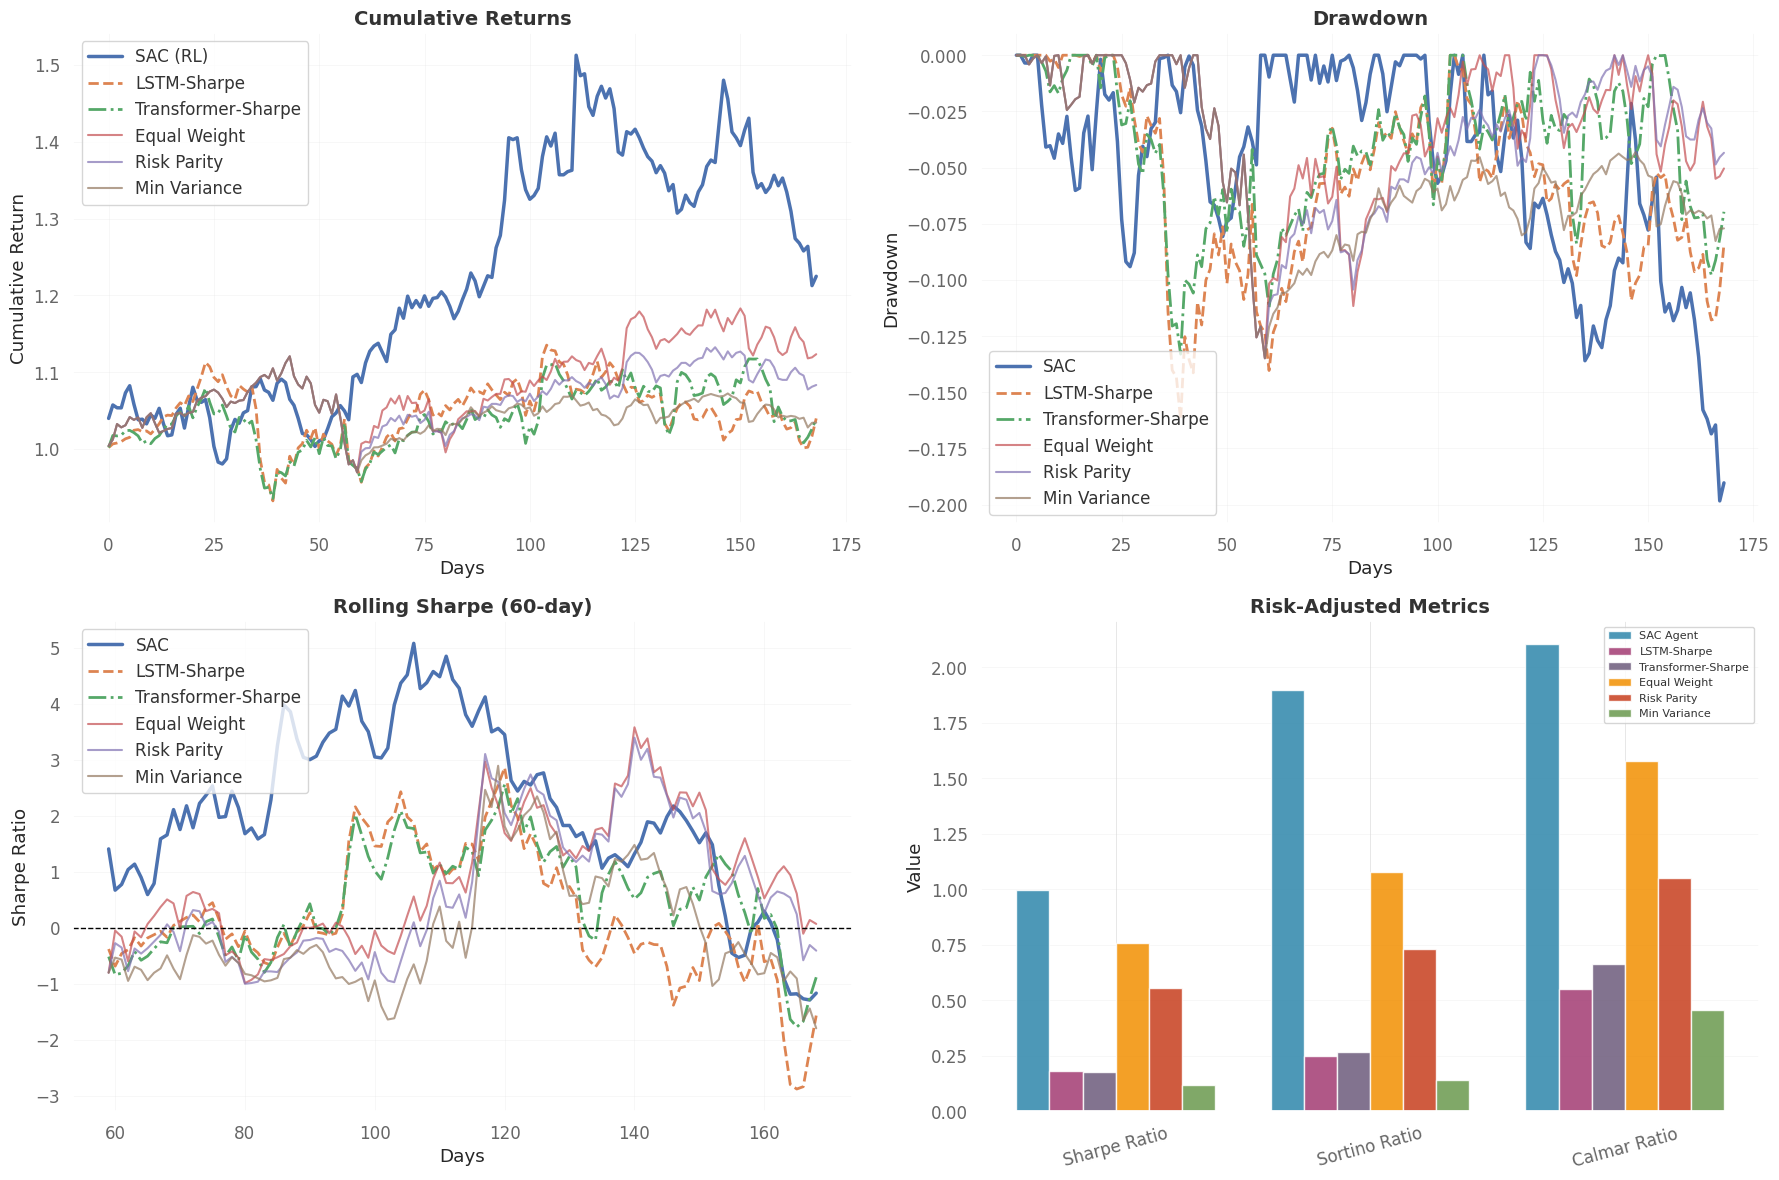

Saved figure as 'final_comparison_sac_lstm_transformer.png'


In [51]:
# Cell 37: Visualization – SAC vs LSTM vs Transformer vs Classical Baselines

import matplotlib.pyplot as plt

# Use aligned returns from Cell 36
sac_cum  = (1 + sac_r).cumprod()
lstm_cum = (1 + lstm_r).cumprod()
tr_cum   = (1 + tr_r).cumprod()
eq_cum   = (1 + eq_r).cumprod()
rp_cum   = (1 + rp_r).cumprod()
mv_cum   = (1 + mv_r).cumprod()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1) Cumulative returns
axes[0, 0].plot(sac_cum,  label="SAC (RL)",        lw=2.5)
axes[0, 0].plot(lstm_cum, label="LSTM‑Sharpe",     lw=2.0, ls="--")
axes[0, 0].plot(tr_cum,   label="Transformer‑Sharpe", lw=2.0, ls="-.")
axes[0, 0].plot(eq_cum,   label="Equal Weight",   lw=1.5, alpha=0.7)
axes[0, 0].plot(rp_cum,   label="Risk Parity",    lw=1.5, alpha=0.7)
axes[0, 0].plot(mv_cum,   label="Min Variance",   lw=1.5, alpha=0.7)
axes[0, 0].set_title("Cumulative Returns", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Days"); axes[0, 0].set_ylabel("Cumulative Return")
axes[0, 0].legend(); axes[0, 0].grid(alpha=0.3)

def drawdown(r):
    s = pd.Series(r)                  # convert to Series
    c = (1 + s).cumprod()
    peak = c.cummax()
    return (c - peak) / peak

axes[0, 1].plot(drawdown(sac_r),  label="SAC",        lw=2.5)
axes[0, 1].plot(drawdown(lstm_r), label="LSTM‑Sharpe", lw=2.0, ls="--")
axes[0, 1].plot(drawdown(tr_r),   label="Transformer‑Sharpe", lw=2.0, ls="-.")
axes[0, 1].plot(drawdown(eq_r),   label="Equal Weight", lw=1.5, alpha=0.7)
axes[0, 1].plot(drawdown(rp_r),   label="Risk Parity",  lw=1.5, alpha=0.7)
axes[0, 1].plot(drawdown(mv_r),   label="Min Variance", lw=1.5, alpha=0.7)
axes[0, 1].set_title("Drawdown", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Days"); axes[0, 1].set_ylabel("Drawdown")
axes[0, 1].legend(); axes[0, 1].grid(alpha=0.3)

# 3) Rolling Sharpe (60‑day)
window = 60
rf_daily = (1 + 0.0442) ** (1 / 252) - 1

def rolling_sharpe(r, win=60):
    return pd.Series(r).rolling(win).apply(
        lambda x: (x.mean() - rf_daily) / (x.std() + 1e-8) * (252 ** 0.5),
        raw=False
    )

axes[1, 0].plot(rolling_sharpe(sac_r, window),  label="SAC",        lw=2.5)
axes[1, 0].plot(rolling_sharpe(lstm_r, window), label="LSTM‑Sharpe", lw=2.0, ls="--")
axes[1, 0].plot(rolling_sharpe(tr_r, window),   label="Transformer‑Sharpe", lw=2.0, ls="-.")
axes[1, 0].plot(rolling_sharpe(eq_r, window),   label="Equal Weight", lw=1.5, alpha=0.7)
axes[1, 0].plot(rolling_sharpe(rp_r, window),   label="Risk Parity",  lw=1.5, alpha=0.7)
axes[1, 0].plot(rolling_sharpe(mv_r, window),   label="Min Variance", lw=1.5, alpha=0.7)
axes[1, 0].axhline(0, color="black", ls="--", lw=1)
axes[1, 0].set_title(f"Rolling Sharpe ({window}-day)", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Days"); axes[1, 0].set_ylabel("Sharpe Ratio")
axes[1, 0].legend(); axes[1, 0].grid(alpha=0.3)

# 4) Bar chart of key metrics
metrics_to_plot = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio"]
strategies = ["SAC Agent", "LSTM-Sharpe", "Transformer-Sharpe",
              "Equal Weight", "Risk Parity", "Min Variance"]
colors = ["#2E86AB", "#A23B72", "#6C5B7B", "#F18F01", "#C73E1D", "#6A994E"]

x = np.arange(len(metrics_to_plot))
width = 0.13

for i, strat in enumerate(strategies):
    vals = [metrics_with_tr[strat][m] for m in metrics_to_plot]
    vals = [min(v, 5) if not np.isinf(v) else 5 for v in vals]  # clip for display
    axes[1, 1].bar(x + i*width, vals, width, label=strat, color=colors[i], alpha=0.85)

axes[1, 1].set_title("Risk‑Adjusted Metrics", fontsize=14, fontweight="bold")
axes[1, 1].set_xticks(x + width*2.5)
axes[1, 1].set_xticklabels(metrics_to_plot, rotation=15)
axes[1, 1].set_ylabel("Value")
axes[1, 1].grid(axis="y", alpha=0.3)
axes[1, 1].legend(fontsize=8)

plt.tight_layout()
plt.savefig("final_comparison_sac_lstm_transformer.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure as 'final_comparison_sac_lstm_transformer.png'")